# Modeling

In [147]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [137]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

TM_A                      TM_B  target
112               Nivalin                   Novalin       1
10                  Seiko                    Seycos       1
254              TRANSICS                   TRINSIC       1
67              GideonsUK                    Gideon       1
175   Gaziantep Pastanesi  GAZIANTEPLILER PASTANESI       1
289  THE HYDE PARK DY GIN          HYDE PARK CORNER       0
303                   CME                 IRSIA CMF       0
314              Revelian                 REBELLION       0
92             SKIN OLOGY                ASKINOLOGY       1
282              THE QUBE                      QUBE       1
95       Nature Farm Food               Farm Nature       1
117             CAMBRIDGE       CAMBRIDGE NeuroTech       1
153         Xtreme Lashes             Xtreme Makeup       1
257                 TIAMA                     TIANA       1
191                    AE                        EE       1
291             SPRAY DRY                 SUPER DRY       0
331                   CEM               CEM 11 plus       0
243               PROGAIN                 PRO GAINS       1
263               GORILLA              GORILLA CAMP       1
141                Bodrum                     Didim       1

In [138]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [139]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [140]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [141]:
from abydos.phones import *

In [142]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [143]:
import re

In [144]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [145]:


# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

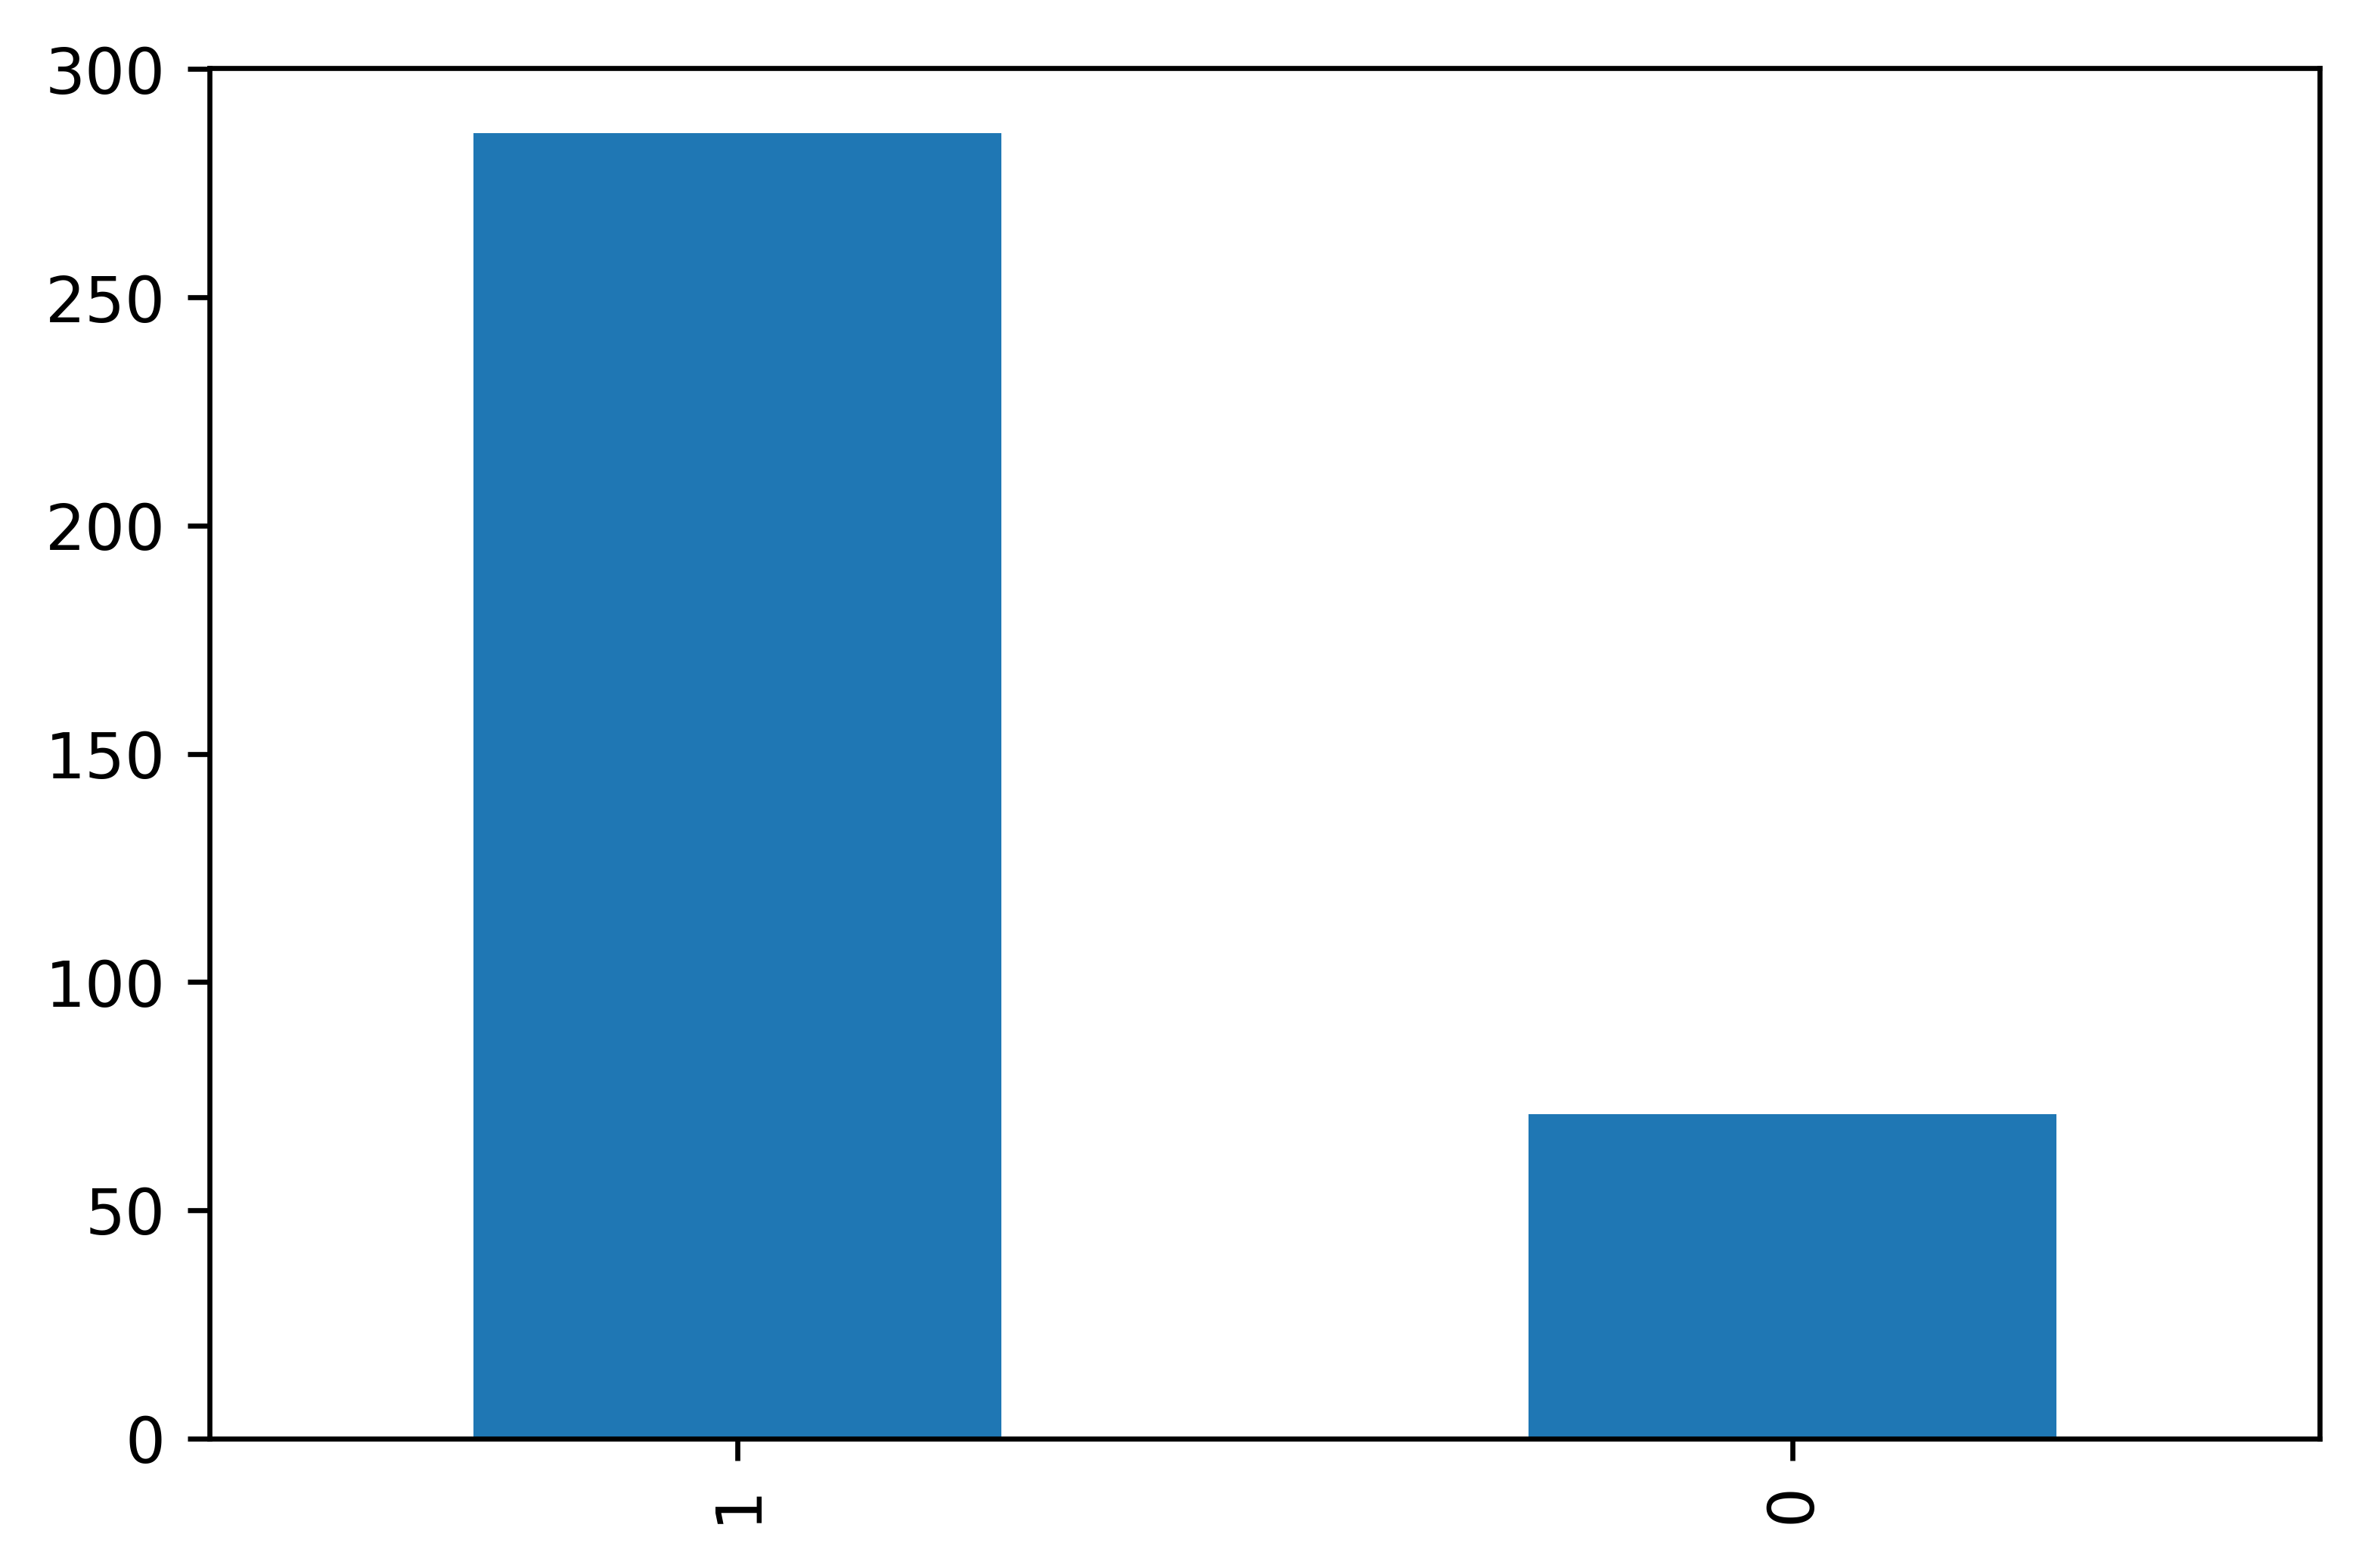

In [148]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [149]:
from itertools import combinations
import random
random.seed(42)


In [150]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=300), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

TM_A                    TM_B
0               DG’S             Woody Stout
1             Gideon                  BOOBOO
2               ULAW          RAW AUTOMATIVE
3            LEPICOL                 Symarom
4        WEALTHSMART                Silk Cut
..               ...                     ...
295      CONNECT.COM                    iiBM
296           Briska                Intelect
297  ayurvedic up&go                 Zanamol
298            UBER   Galaxy Print Finishing
299   Flip’n Chicken                  HiGeen

[300 rows x 2 columns]

In [151]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:1


In [152]:
nonmatch_cases.sample(20)

TM_A                             TM_B
125               SIMTEK                        URBAN FOX
223              ESSENTA                            Curve
291          Harry’s Bar                     Content Guru
239    Swisslife Forever                          EMOLITE
261              Zanamol             The Science of Stoke
198               Cozirc                            Didim
126        Xtreme Lashes                        DERMAVEEL
134         WECASABLANCA                            OPALS
75            DG FASHION                    ERIS EXCHANGE
181  Smartworking Summit                       Dank Vapes
30                  FLYE                          HORIZON
296               Briska                         Intelect
287            PRO GAINS                            CELIO
225         + Class View                        FENESTRAE
140                MILAN                             OPAL
284               ezyVet  LA FRANCAISE investing together
28       Maternity Yours                    Platinum Plus
289          Snake Brand                              OVO
8         MONSTER ENERGY                        CAMBRIDGE
295          CONNECT.COM                             iiBM

In [153]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

class_balanced

# class_balanced[class_balanced['TM_B'].str.len()!=0]


TM_A                 TM_B  target
0            Simoniz            Permanize       1
1           Magnavoc             Multivox       1
2              Zirco               Cozirc       1
3      Platinum Puff        Platinum Plus       1
4    Maternity Yours  Your Maternity Shop       1
..               ...                  ...     ...
352           Lilton               Wilton       0
353         Nutricia             Nutritea       0
354        Glenreidh            An Reidhe       0
355  No Gunk No Junk    No Gunk Just Funk       0
356         e-Relief         LIGHT RELIEF       0

[657 rows x 3 columns]

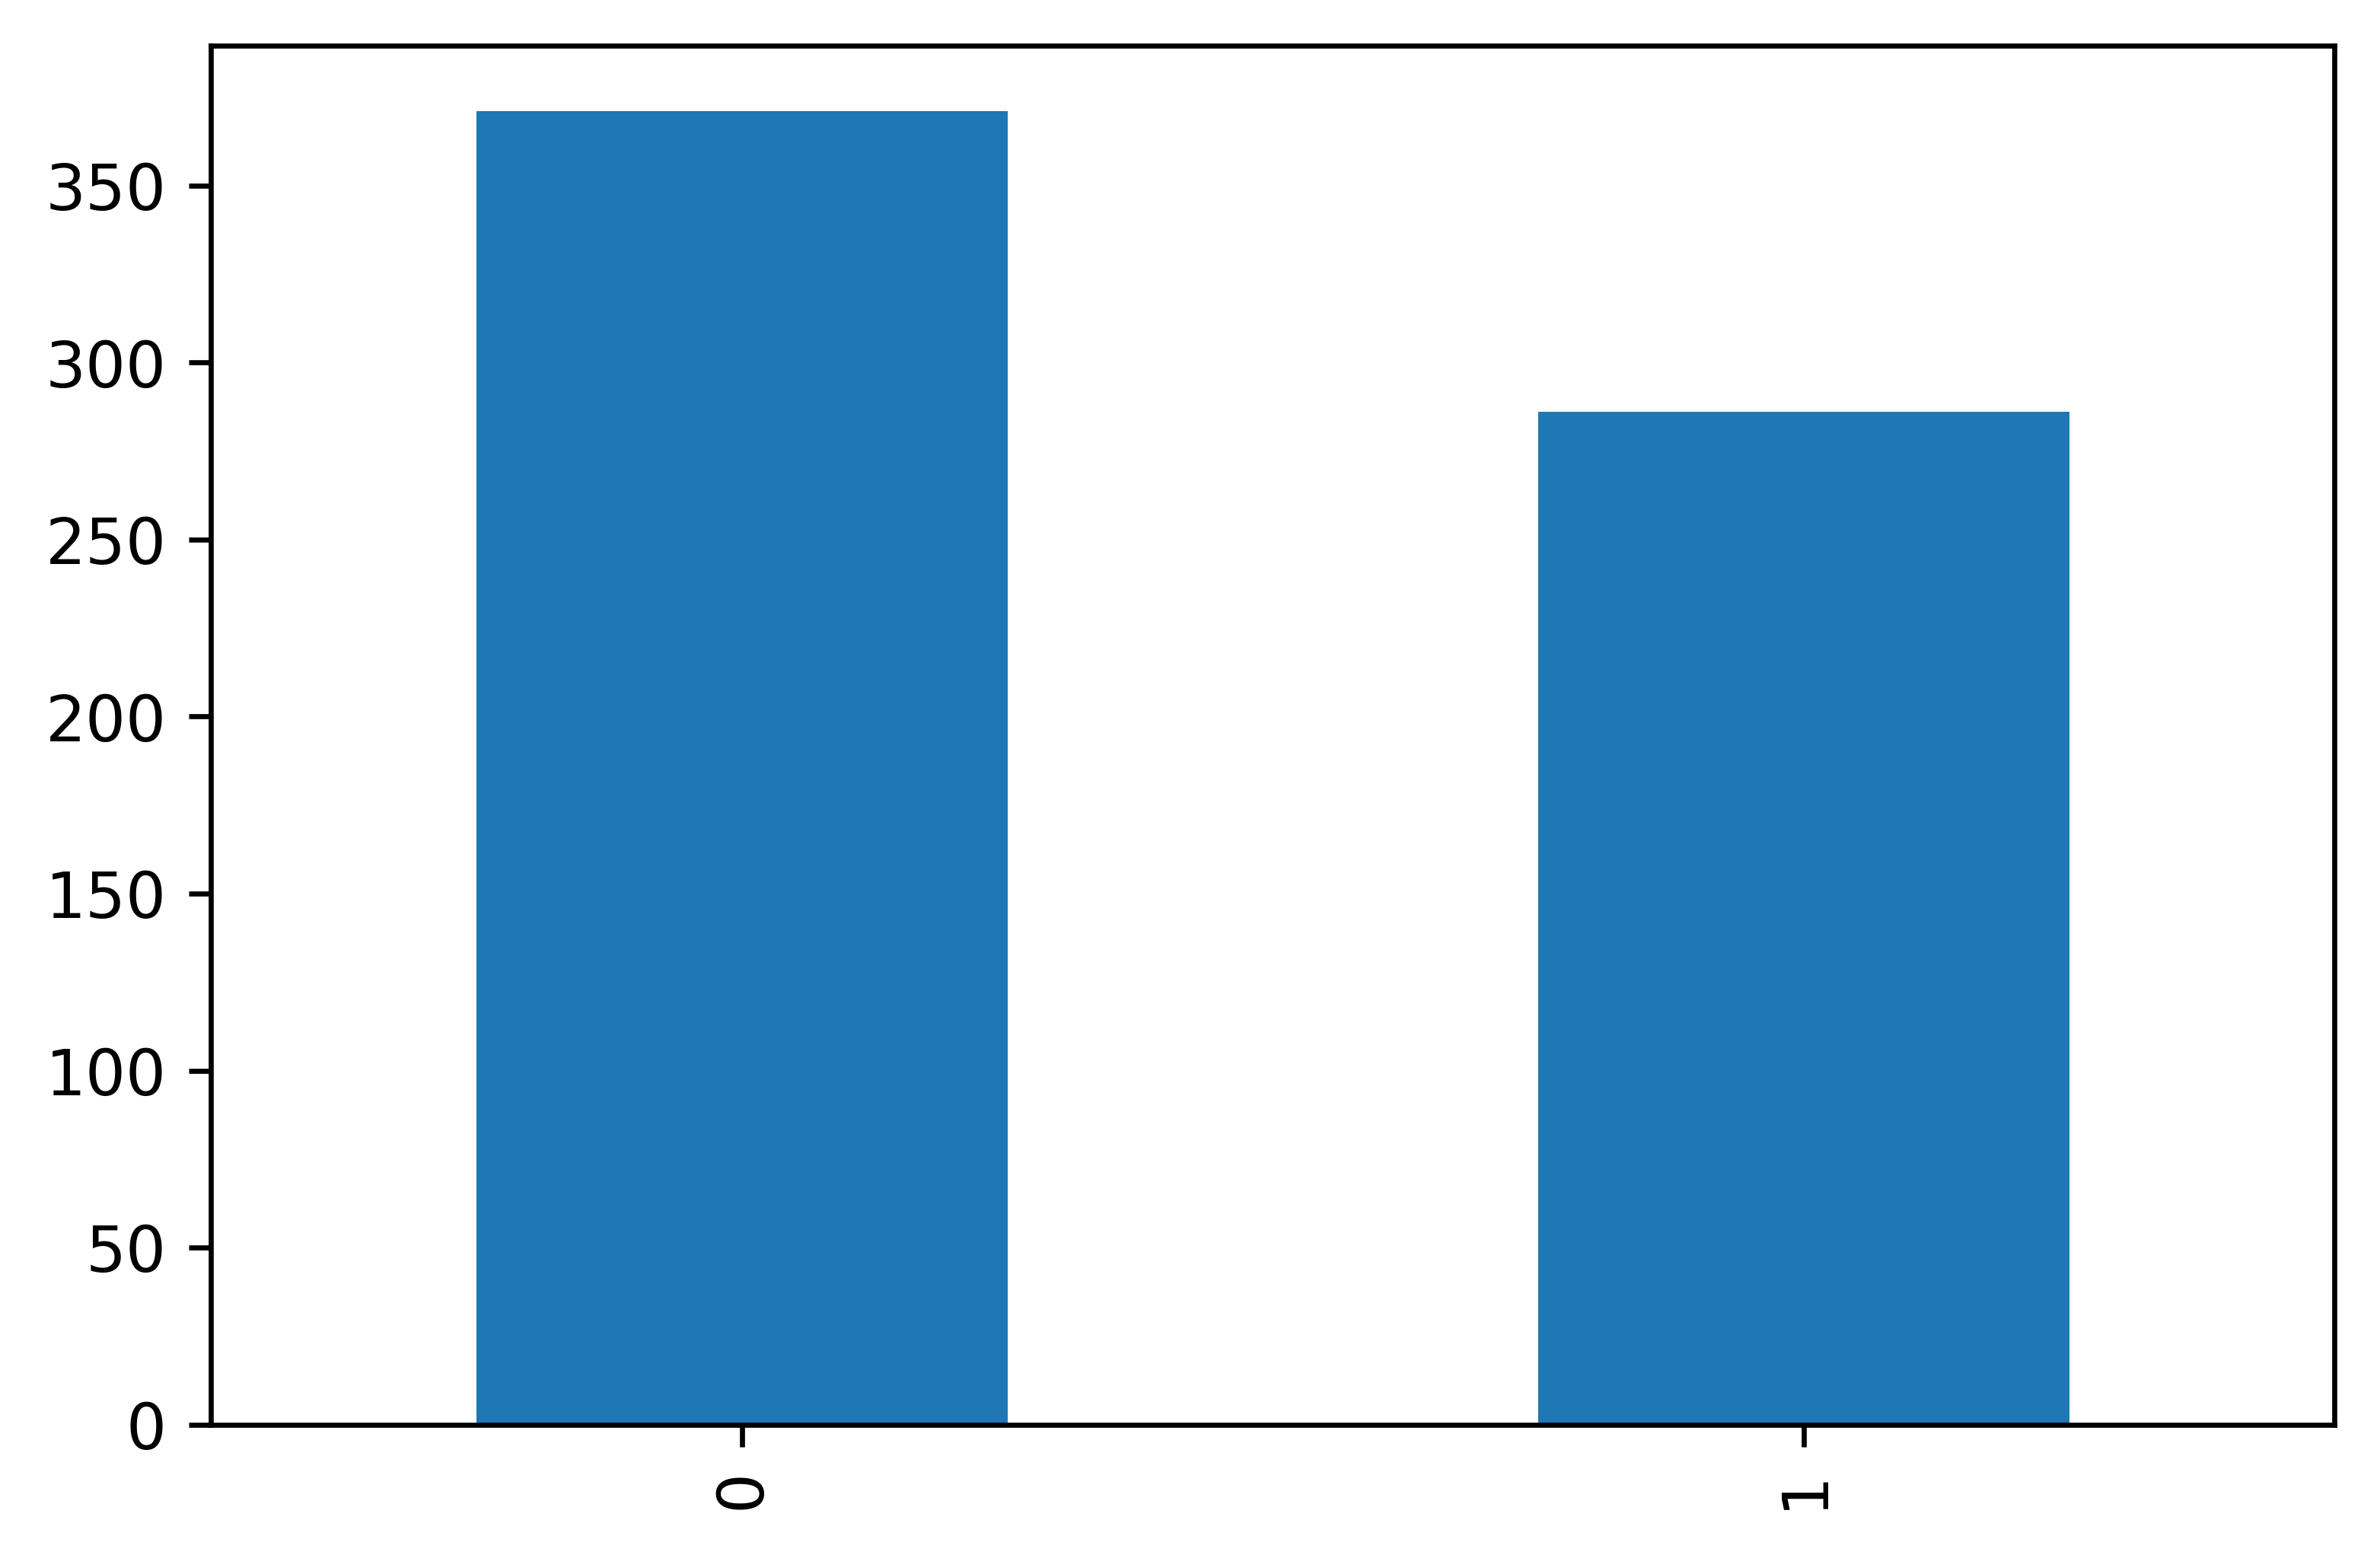

In [154]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [155]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


a                         b  target  \
339              LA MERCI                     MERCI       0   
204              THE BLUE                  BLUE.COM       1   
20      Suisman & Shapiro       Suisman and Shapiro       1   
13               Intelect                   Entelec       1   
201                  AURA               AURA LUSTRE       1   
49       Harleydietitians             Harley Clinic       1   
1                Magnavoc                  Multivox       1   
178               MOSCANY                   TOSKANI       1   
36                  DRNOW             Xtreme Makeup       0   
326       MARK ADAMS NO 1                   MARK 10       0   
94              HARD CORE                        AE       0   
230                 UBER                    UBERJET       1   
176             LIFESTYLE             ERIS EXCHANGE       0   
40   The Science of Stoke                     Stoke       1   
175   Gaziantep Pastanesi  GAZIANTEPLILER PASTANESI       1   
167                  LOCO                      LOKA       1   
261                RELATE                   RELATED       1   
289  THE HYDE PARK DY GIN          HYDE PARK CORNER       0   
190                   SKY                   SKYCLAD       1   
274                WARTIE                   WARTNER       1   

                   TM_A                     TM_B  partial  tkn_sort  tkn_set  \
339             lamerci                    merci      100        83       83   
204             theblue                  bluecom       57        57       57   
20       suismanshapiro        suismanandshapiro       79        90       90   
13             intelect                  entelec       86        80       80   
201                aura               auralustre      100        57       57   
49     harleydietitians             harleyclinic       67        57       57   
1              magnavoc                 multivox       38        38       38   
178             moscany                  toskani       57        57       57   
36                drnow             xtrememakeup       20        12       12   
326         markadamsno                     mark      100        53       53   
94             hardcore                       ae       50        40       40   
230                uber                  uberjet      100        73       73   
176           lifestyle             erisexchange       33        29       29   
40    thescienceofstoke                    stoke      100        45       45   
175  gazianteppastanesi  gazianteplilerpastanesi       72        88       88   
167                loco                     loka       50        50       50   
261              relate                  related      100        92       92   
289    thehydeparkdygin           hydeparkcorner       67        60       60   
190                 sky                  skyclad      100        60       60   
274              wartie                  wartner       83        77       77   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
339  0.483871     0.057143          0       0              0   
204  0.669355     0.171429          0       0              0   
20   0.848118     0.085714          0       0              1   
13   0.870968     0.057143          0       0              0   
201  1.000000     0.171429          0       0              0   
49   0.552419     0.228571          0       0              0   
1    0.691532     0.142857          0       0              0   
178  0.963134     0.085714          0       0              0   
36   0.793548     0.314286          0       0              0   
326  0.272727     0.200000          0       0              0   
94   0.306452     0.171429          0       0              0   
230  1.000000     0.085714          0       0              0   
176  0.562724     0.257143          0       0              0   
40   0.173118     0.342857          0       0              0   
175  0.861111     0.142857          0       0              

#### Export clean data to csv

In [156]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [157]:
y = df.target
X = df.drop(columns = 'target')

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [160]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [161]:
from tpot import TPOTClassifier

In [162]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [163]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [164]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [165]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

target  partial  tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  \
0         1       57        50       50  0.658986     0.142857          0   
1         1       38        38       38  0.691532     0.142857          0   
2         1       89        73       73  0.806452     0.085714          0   
3         1       83        83       83  0.895161     0.085714          0   
4         1       74        65       65  0.743176     0.257143          0   
..      ...      ...       ...      ...       ...          ...        ...   
352       0       83        83       83  0.943548     0.028571          0   
353       0       75        75       75  0.874552     0.057143          0   
354       0       80        71       71  0.498208     0.114286          0   
355       0       67        77       77  0.822581     0.142857          0   
356       0       86        67       67  0.629032     0.142857          0   

     nysiis  mtch_rtng_cdx  pshp_soundex_first  iterativesubstring     bisim  \
0         0              0                   0            0.485480  0.388889   
1         0              0                   0            0.050000  0.437500   
2         0              0                   0            0.821263  0.583333   
3         0              0                   1            0.884677  0.833333   
4         0              0                   0            0.951613  0.588235   
..      ...            ...                 ...                 ...       ...   
352       0              0                   0            0.897436  0.750000   
353       0              0                   1            0.804167  0.750000   
354       0              0                   0            0.800858  0.611111   
355       0              0                   1            0.852383  0.678571   
356       0              0                   0            0.793397  0.500000   

     discountedlevenshtein  prefix    lcsstr  mlipns  strcmp95       mra  \
0                 0.383752   0.000  0.333333     0.0  0.722751  0.666667   
1                 0.366778   0.125  0.250000     0.0  0.633333  0.500000   
2                 0.495199   0.000  0.666667     0.0  0.822222  0.833333   
3                 0.818487   0.750  0.750000     1.0  0.933333  0.500000   
4                 0.472052   0.000  0.529412     0.0  0.700700  0.000000   
..                     ...     ...       ...     ...       ...       ...   
352               0.796089   0.000  0.833333     1.0  0.822222  0.833333   
353               0.798406   0.625  0.625000     1.0  0.915000  0.833333   
354               0.510437   0.000  0.666667     0.0  0.741402  0.666667   
355               0.700763   0.500  0.428571     0.0  0.898810  0.833333   
356               0.479055   0.000  0.545455     0.0  0.713131  0.500000   

       editex      saps  flexmetric      jaro  higueramico     sift4  \
0    0.555556  0.137931    0.566667  0.671958     0.430556  0.444444   
1    0.500000  0.304348    0.400000  0.583333     0.375000  0.375000   
2    0.500000  0.428571    0.600000  0.822222     0.547619  0.666667   
3    0.833333  0.666667    0.833333  0.888889     0.769231  0.833333   
4    0.588235  0.319149    0.538235  0.687675     0.490372  0.588235   
..        ...       ...         ...       ...          ...       ...   
352  0.833333  0.500000    0.833333  0.822222     0.833333  0.833333   
353  0.812500  0.565217    0.787500  0.833333     0.750000  0.750000   
354  0.666667  0.310345    0.666667  0.741402     0.588889  0.666667   
355  0.678571  0.469388    0.700000  0.815873     0.637363  0.714286   
356  0.636364  0.166667    0.663636  0.689755     0.482071  0.363636   

        eudex     aline  phoneticeditdistance  
0    0.654902  0.602128              0.727599  
1    0.916667  0.545455              0.897177  
2    0.786275  0.705882              0.634409  
3    1.000000  0.873529              0.913978  
4    0.463725  0.589655              0.646110  
..        ...       ...                   ...  
352  

In [166]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [167]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [168]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.39363407678800005,
 0.6662545340021258,
 0.16226549329652354,
 0.6108412491703392,
 0.16262806781990533,
 0.6751355478636278,
 0.7097493726505187,
 0.16210144833038442,
 0.6865889867699707,
 0.7058867656378408,
 0.16210144833038442,
 0.6316492446512758,
 0.6729584131321841,
 0.16210144833038442,
 0.16283361375579286,
 0.17542103753542493,
 0.16210144833038442,
 0.16210144833038442,
 0.7013433664944376,
 0.6656328337749539,
 0.6609428727184031,
 0.6361119951361904,
 0.7545534974792548,
 0.16210144833038442,
 0.16262806781990533,
 0.2943186761336868,
 0.6721301594038152,
 0.16210144833038442,
 0.16210144833038442,
 0.16210144833038442,
 0.7417434235797068,
 0.7227301282669212,
 0.16279254217757594,
 0.5584134533635778,
 0.7516808026655624,
 0.5773703513745875,
 0.6666752922909699,
 0.5675854864916594,
 0.7415806261720055,
 0.6481348899425696,
 0.33088894619258147,
 0.16342375342599413,
 0.7424257796308809,
 0.24314285202231287,
 0.7057380344084793,
 0.16210144833038442,
 0.69402639837

## K-fold cross validation

In [169]:
from sklearn.model_selection import StratifiedKFold

In [170]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
#     oof_pred['predict_probXGB'] = base_model_2(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
#                                       y_train,
#                                       X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [171]:
meta_training.sample(20)

TM_A                          TM_B  predict_proba  target
292               iibm                         ponim       0.175325       0
135   investedtogether                  healthytimes       0.167009       0
336        astonmartin                     astonhill       0.596776       0
213                ofo                     dgfashion       0.167389       0
71   togetherforbetter                   kinkcentral       0.167267       0
191         sohogarden                           tss       0.170030       0
111              denim                      transics       0.167009       0
176     wholefoodearth              wholefoodsmarket       0.662375       1
40                kozo               theuglykidsclub       0.167172       0
236           hamilton                         seven       0.165897       0
290    purebusinesslaw  advantageholidaysbyadvantage       0.167389       0
70           reprolene               wildwoodkitchen       0.169234       0
13            intelect                       entelec       0.661087       1
53                kool                      koolshot       0.748565       1
139        canvashomes               canvaslifestyle       0.606206       1
260         auralustre                      urbaneat       0.183805       0
106              poynt                          kink       0.230397       0
98               savvy                           tss       0.188461       0
265             boohoo                        booboo       0.709260       1
291          harrysbar                   contentguru       0.167389       0

### Meta-Model: Logistic Regression

In [172]:
df=featurize(meta_training)

In [173]:
df.sample(20)

a                 b  predict_proba  target  \
262              mideltone          finastra       0.173029       0   
3             platinumpuff      platinumplus       0.652301       1   
89                 izirize          liberize       0.629708       1   
34                progains             anker       0.167267       0   
338         growlerbeersuk   gruntinggrowler       0.614201       0   
83                cephalus          cephalon       0.656192       1   
207                 vesper           vespers       0.660891       1   
14                   sabis        foverwatch       0.168707       0   
156              skinology     beatriceperry       0.168115       0   
8            monsterenergy         cambridge       0.167172       0   
288  oceanspraycranberries  oceangardenprods       0.572529       0   
173               westlake          westlake       0.646378       1   
275                  milan       milansweets       0.748398       1   
233           neverweather          neverwet       0.715728       1   
59                   veype              zena       0.201591       0   
300                  rives            rivers       0.668884       0   
275                      m             curve       0.181956       0   
172           xtrememakeup               aeg       0.173069       0   
269                 seycos      erisexchange       0.182522       0   
240                   pepe     pepespiripiri       0.687606       1   

                      TM_A              TM_B  partial  tkn_sort  tkn_set  \
262              mideltone          finastra       25        24       24   
3             platinumpuff      platinumplus       83        83       83   
89                 izirize          liberize       71        67       67   
34                progains             anker       40        31       31   
338         growlerbeersuk   gruntinggrowler       50        48       48   
83                cephalus          cephalon       75        75       75   
207                 vesper           vespers      100        92       92   
14                   sabis        foverwatch       20        13       13   
156              skinology     beatriceperry       22        18       18   
8            monsterenergy         cambridge       22        27       27   
288  oceanspraycranberries  oceangardenprods       50        54       54   
173               westlake          westlake      100       100      100   
275                  milan       milansweets      100        62       62   
233           neverweather          neverwet       88        80       80   
59                   veype              zena       25        22       22   
300                  rives            rivers       80        91       91   
275                      m             curve        0         0        0   
172           xtrememakeup               aeg       67        27       27   
269                 seycos      erisexchange       50        33       33   
240                   pepe     pepespiripiri      100        47       47   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
262  0.818548     0.200000          0       0              0   
3    0.895161     0.085714          0       0              0   
89   0.706452     0.085714          0       0              0   
34   0.310036     0.228571          0       0              0   
338  0.759217     0.371429          0       0              0   
83   0.976959     0.057143          0       0              0   
207  1.000000     0.028571          0       1              0   
14   0.877419     0.257143          0       0              0   
156  0.763441     0.314286          0       0              0   
8    0.669355     0.314286          0       0              0   
288  0.569124     0.342857          0       0              0   
173  1.000000     0.000000          1       1              1   
275  1.000000     0.171429          0       0              0   
233  0.867384     0.114286          0   

### Evaluate Gradient Boosting Classifier

In [180]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[31  6]
 [ 3 25]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        37
           1       0.81      0.89      0.85        28

    accuracy                           0.86        65
   macro avg       0.86      0.87      0.86        65
weighted avg       0.87      0.86      0.86        65



In [181]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [182]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.908')

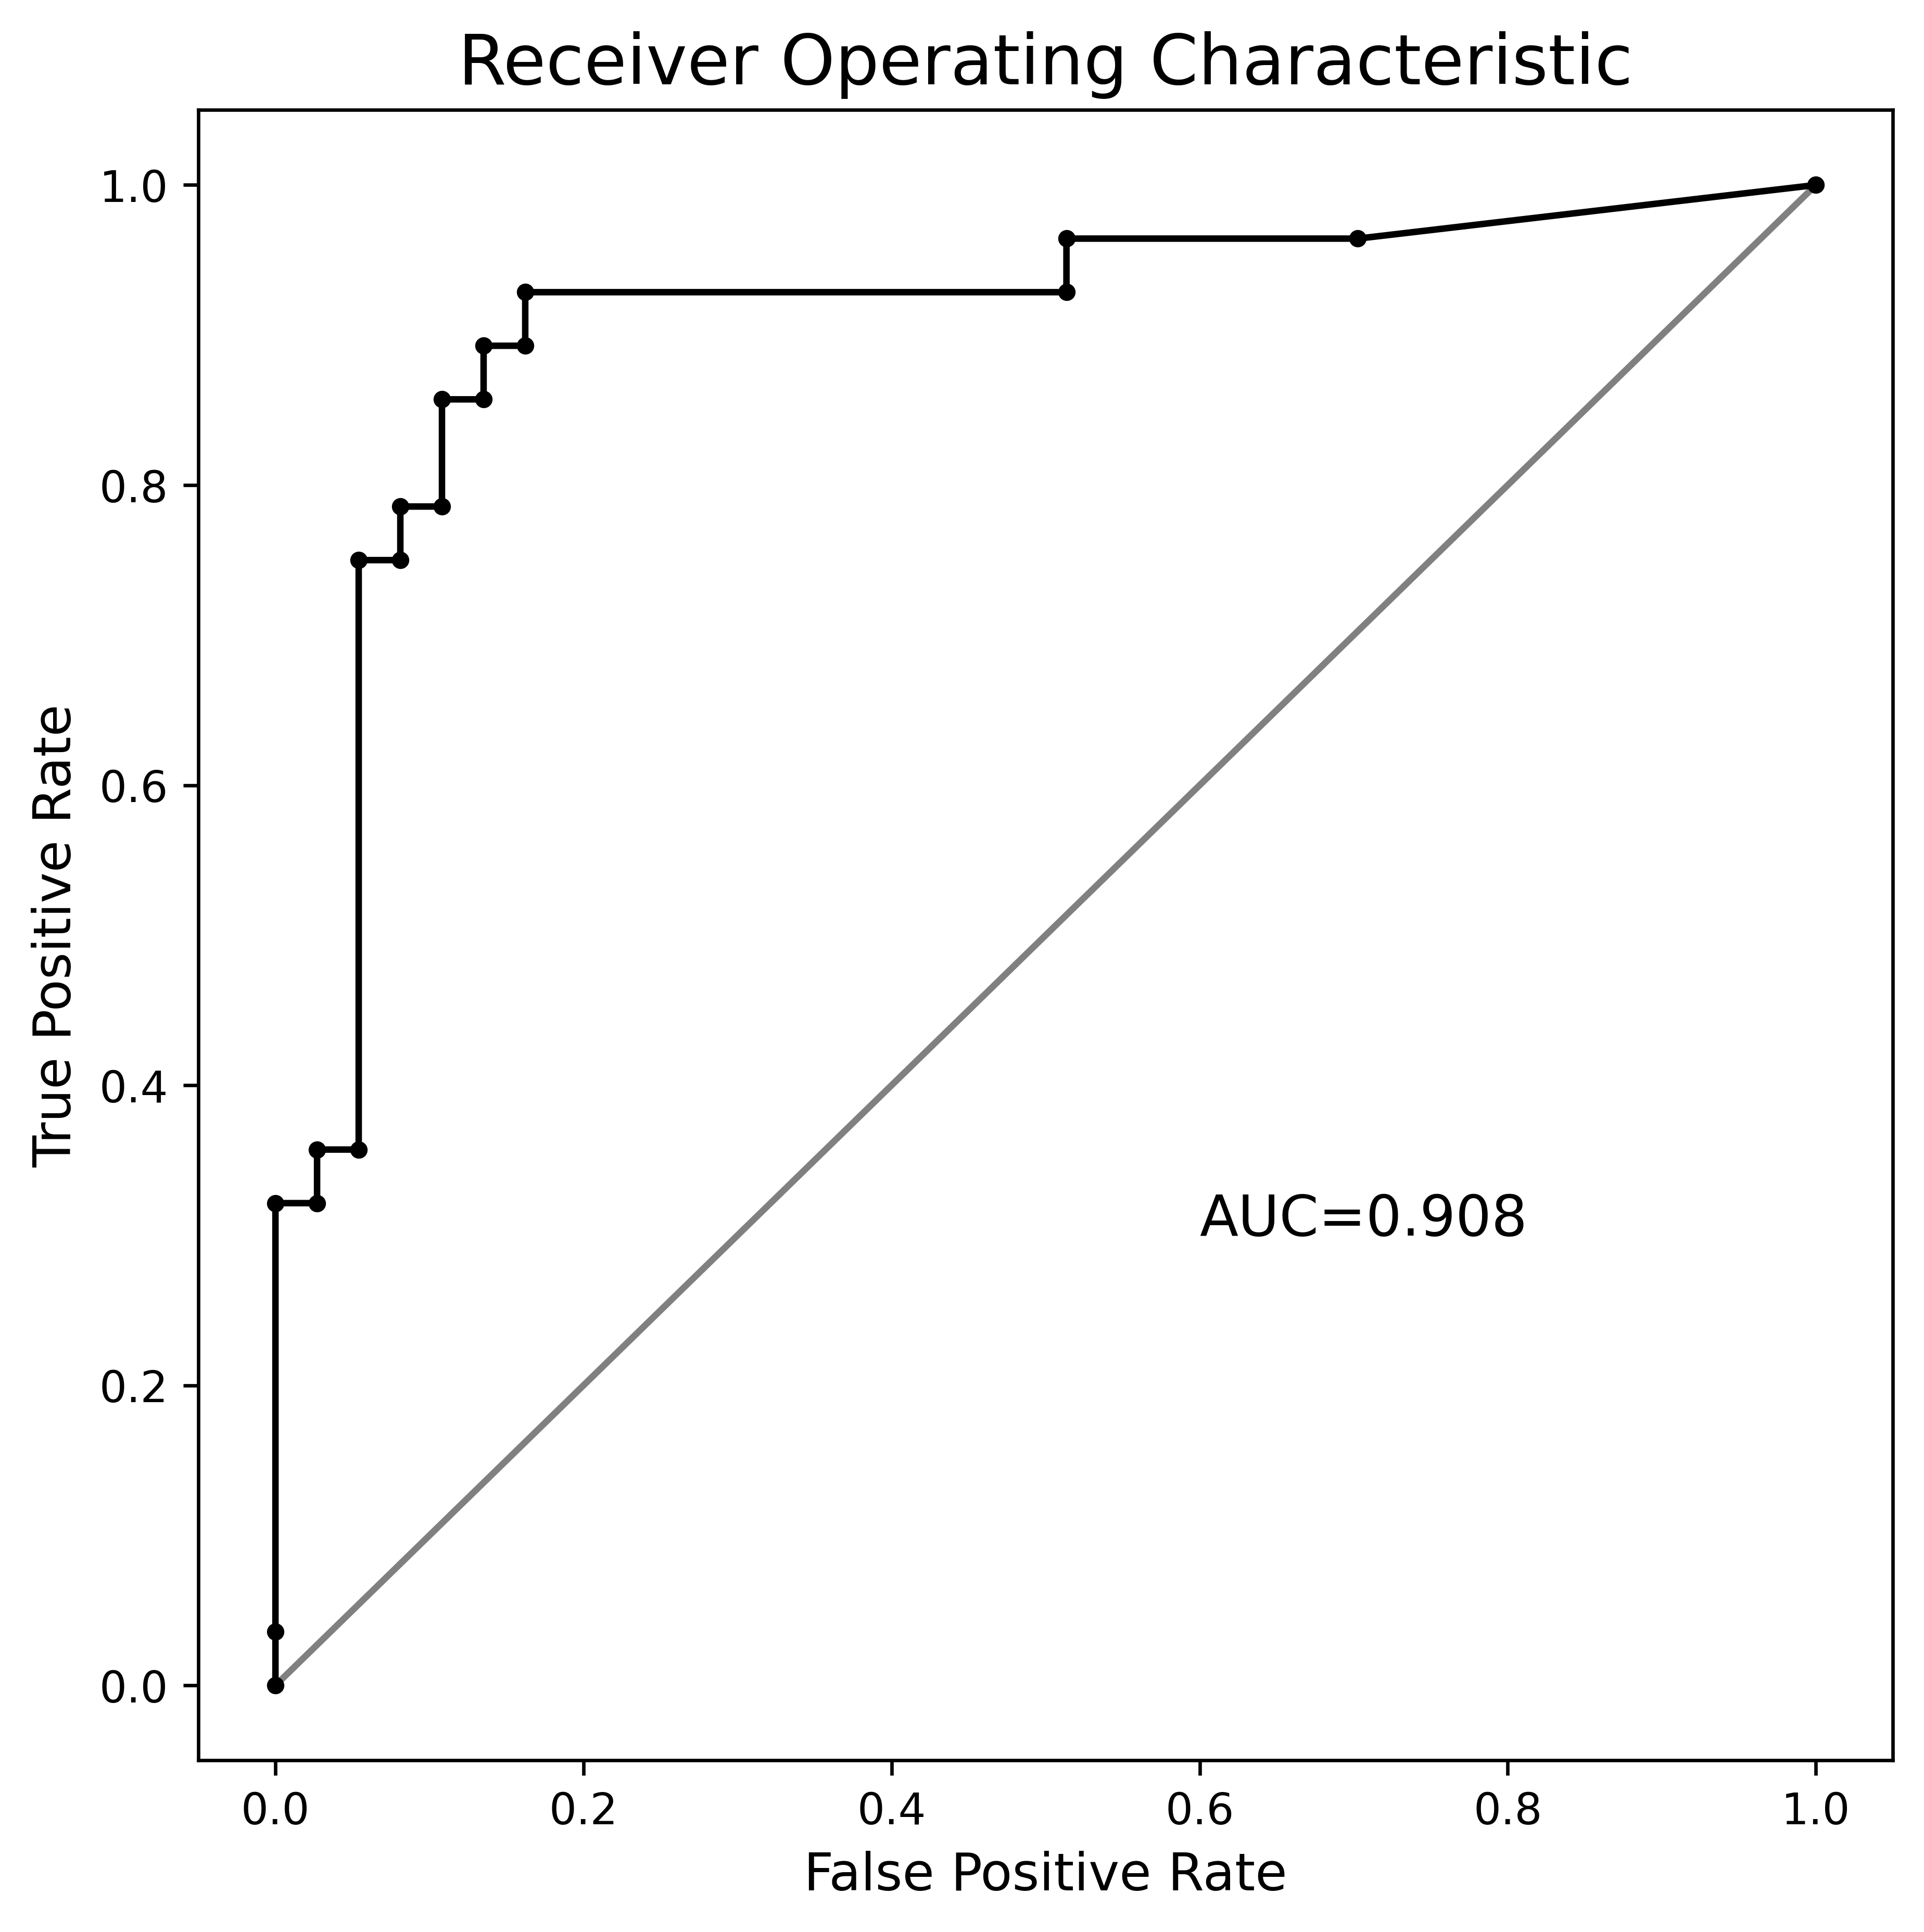

In [183]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

In [184]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [185]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(gb_clf2)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar")

AssertionError: Summary plots need a matrix of shap_values, not a vector.

# XGboost

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


X

In [ ]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [186]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

ValueError: Found input variables with inconsistent numbers of samples: [65, 132]

In [187]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

### Evaluate XGboost

In [192]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.878')

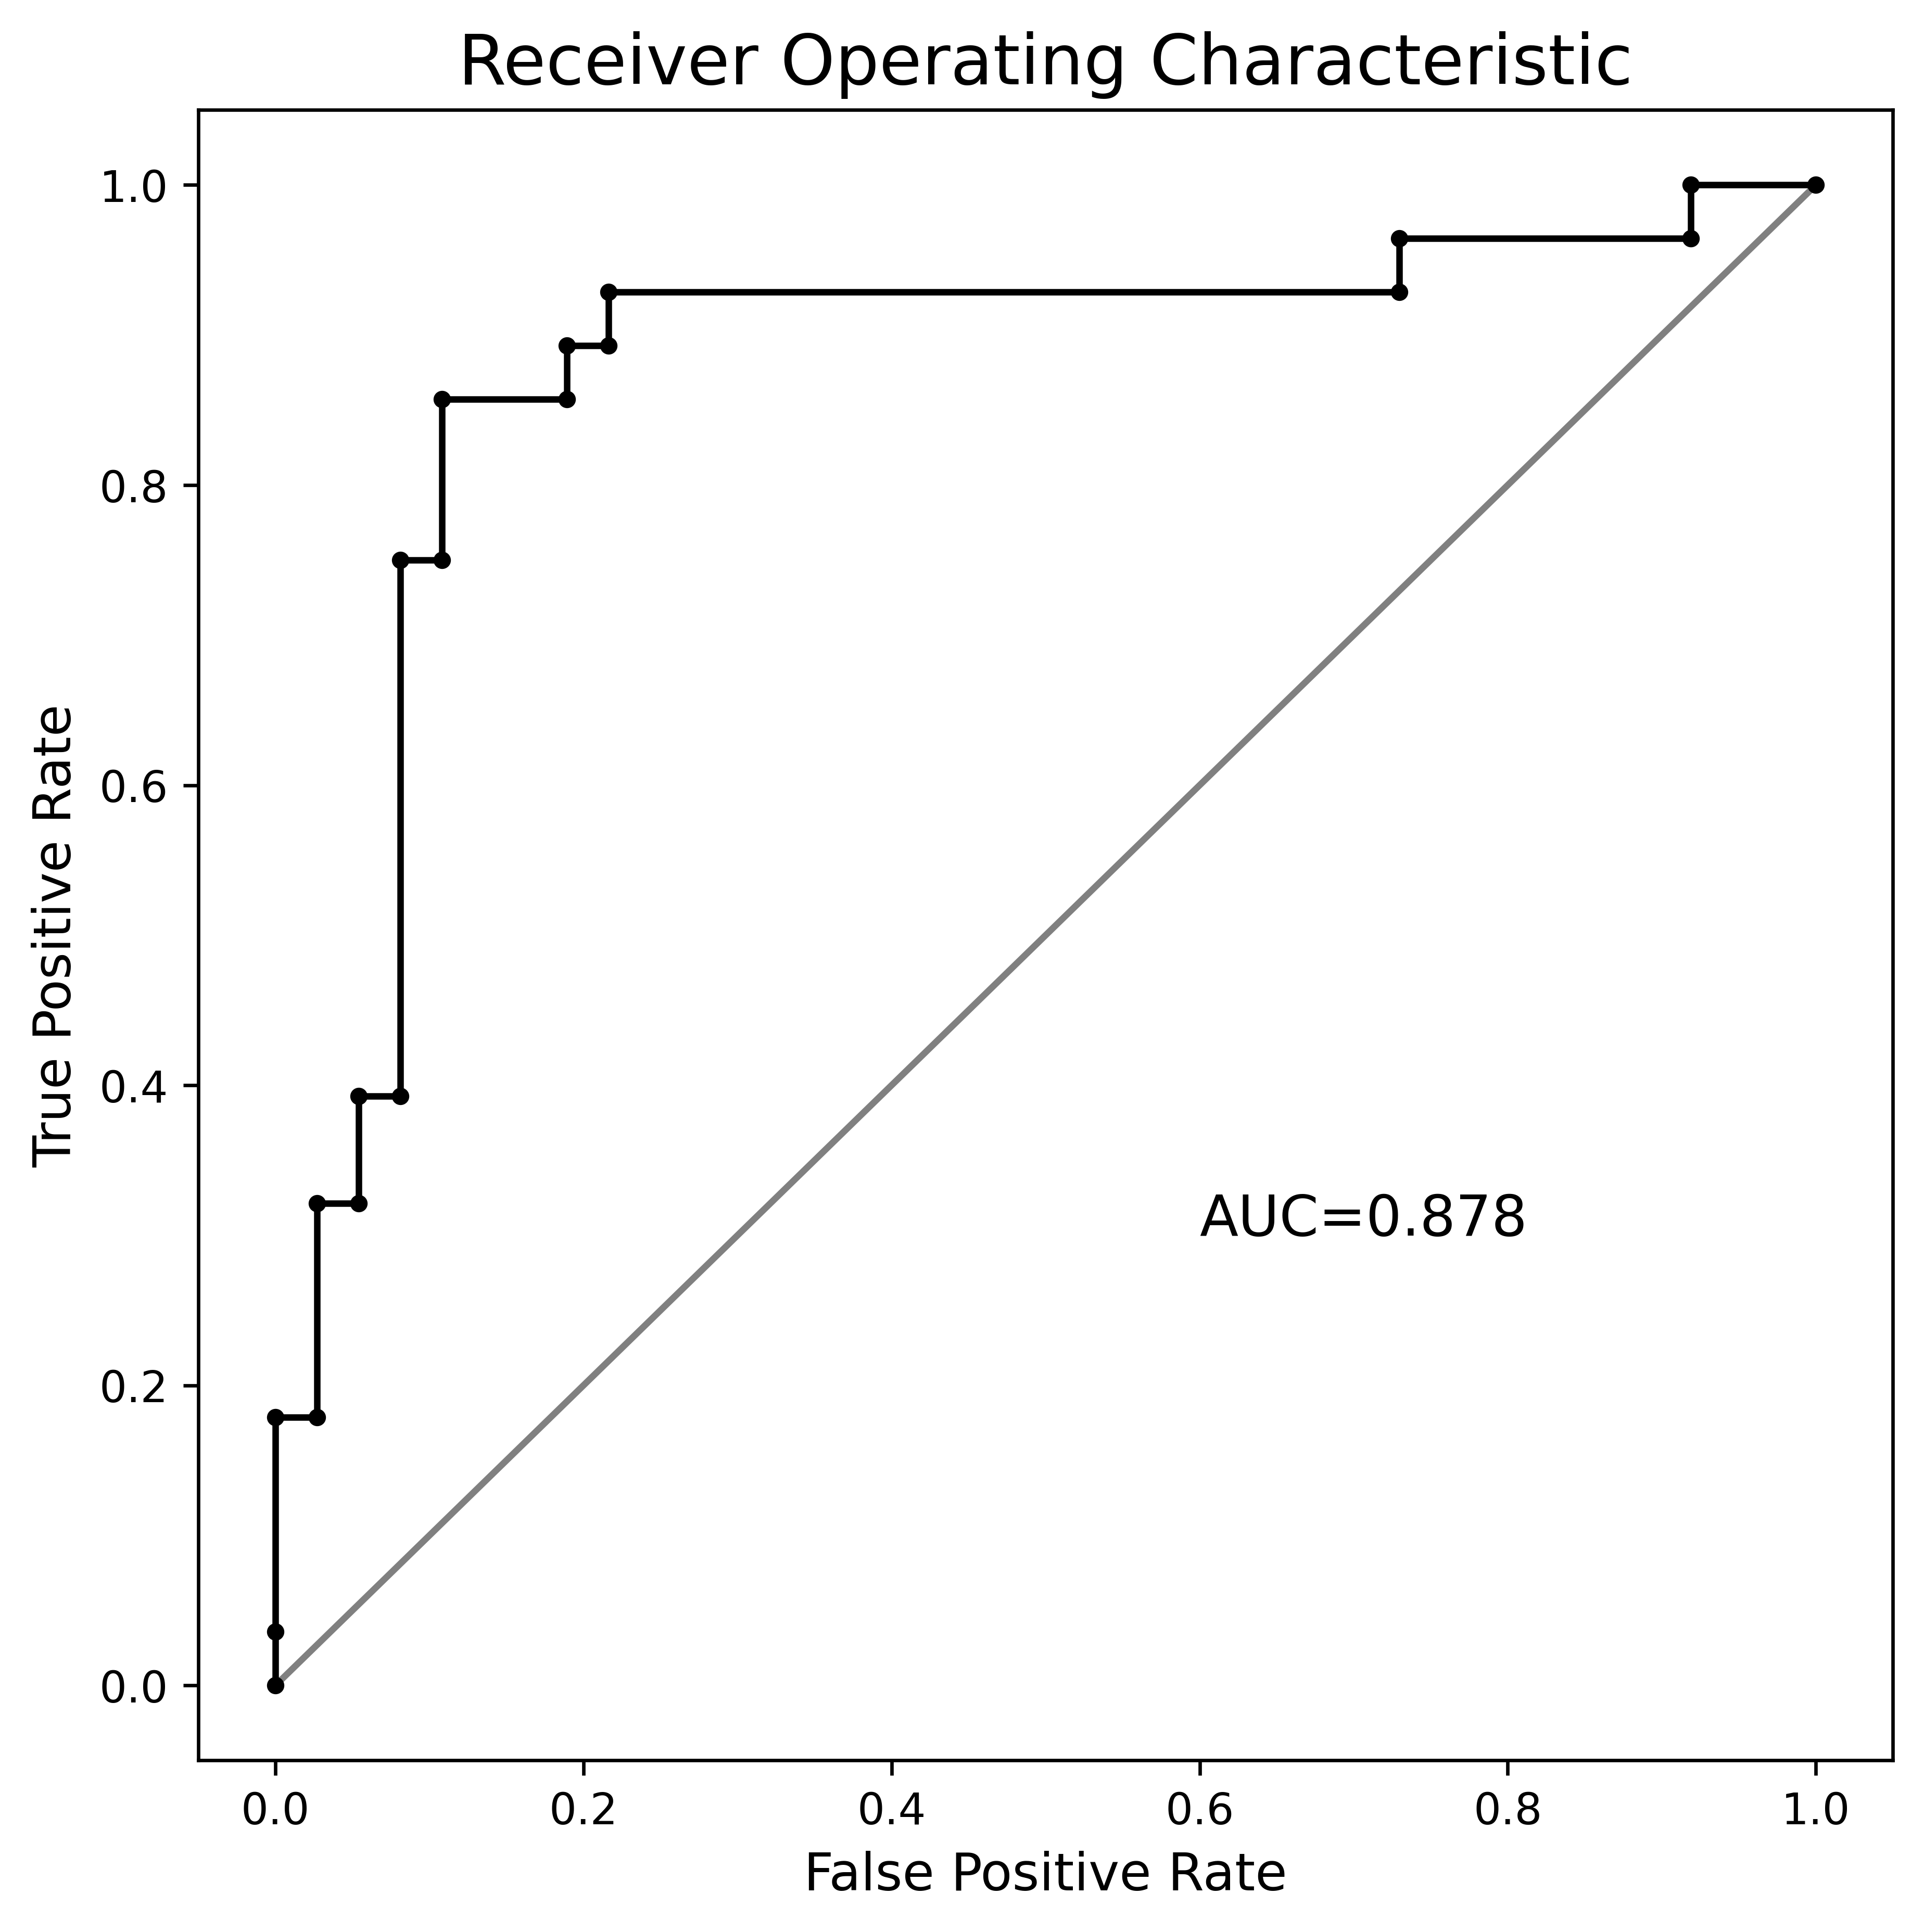

In [193]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 300)

In [194]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

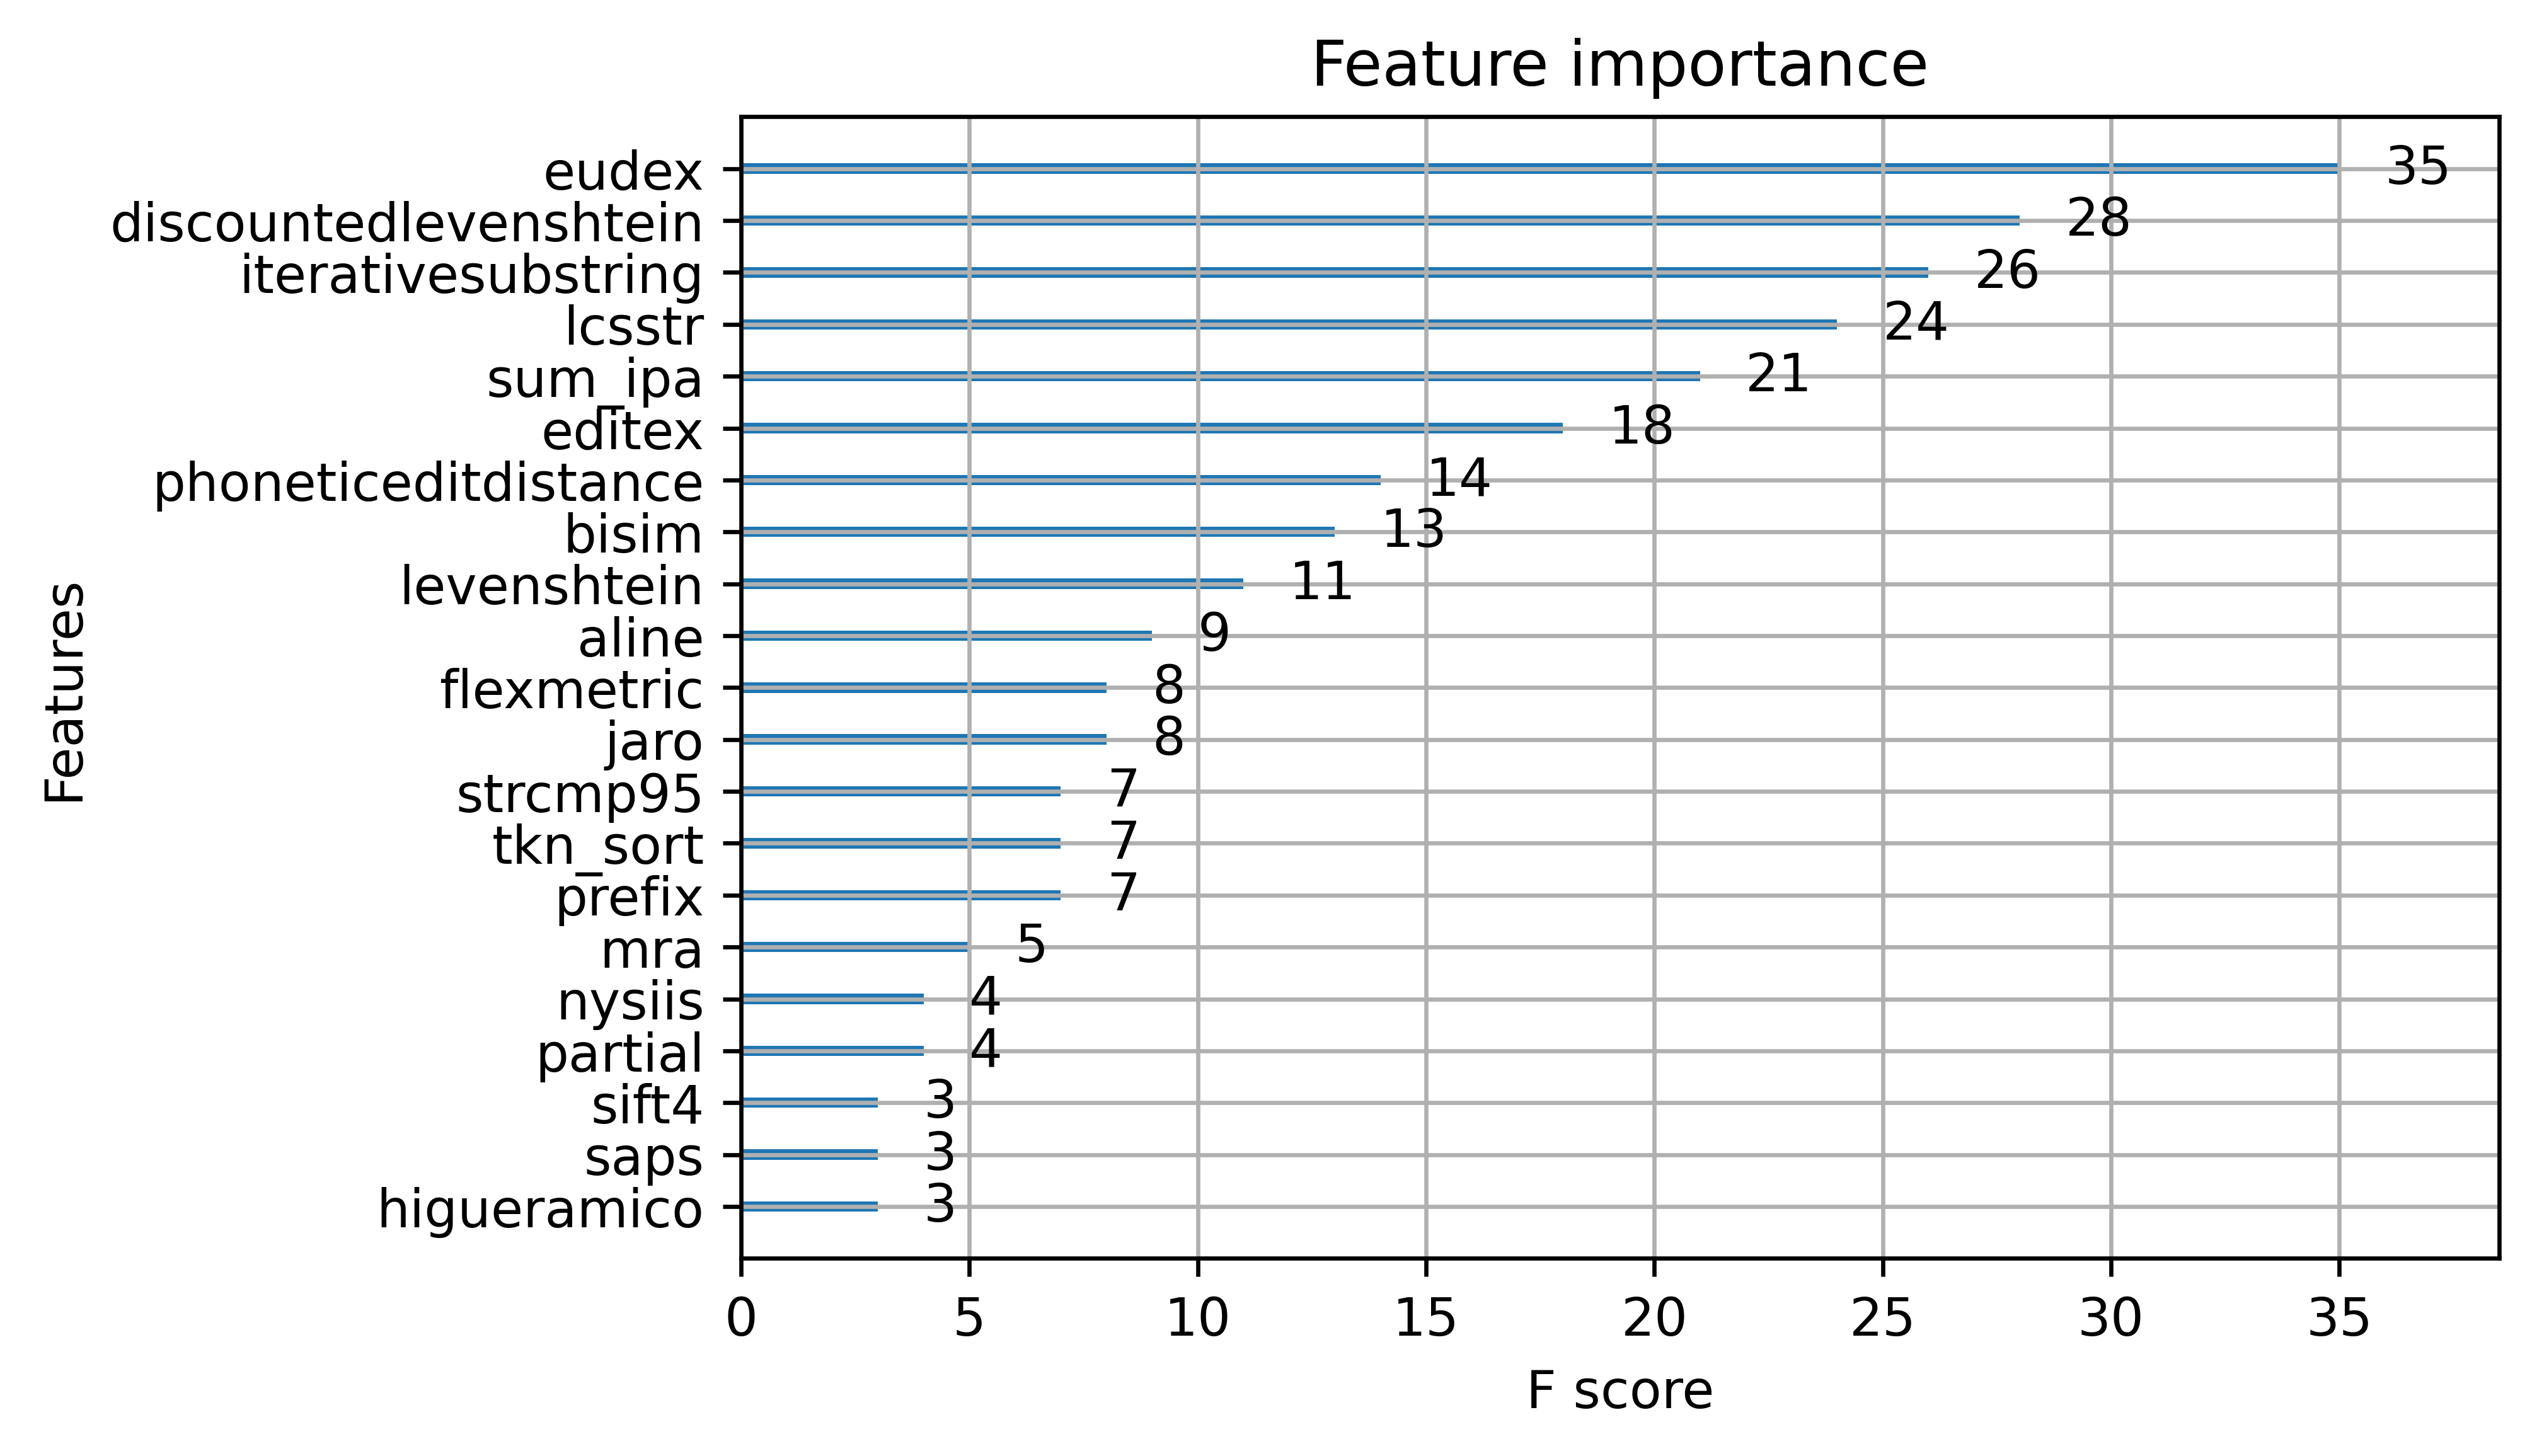

In [190]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
pyplot.show()

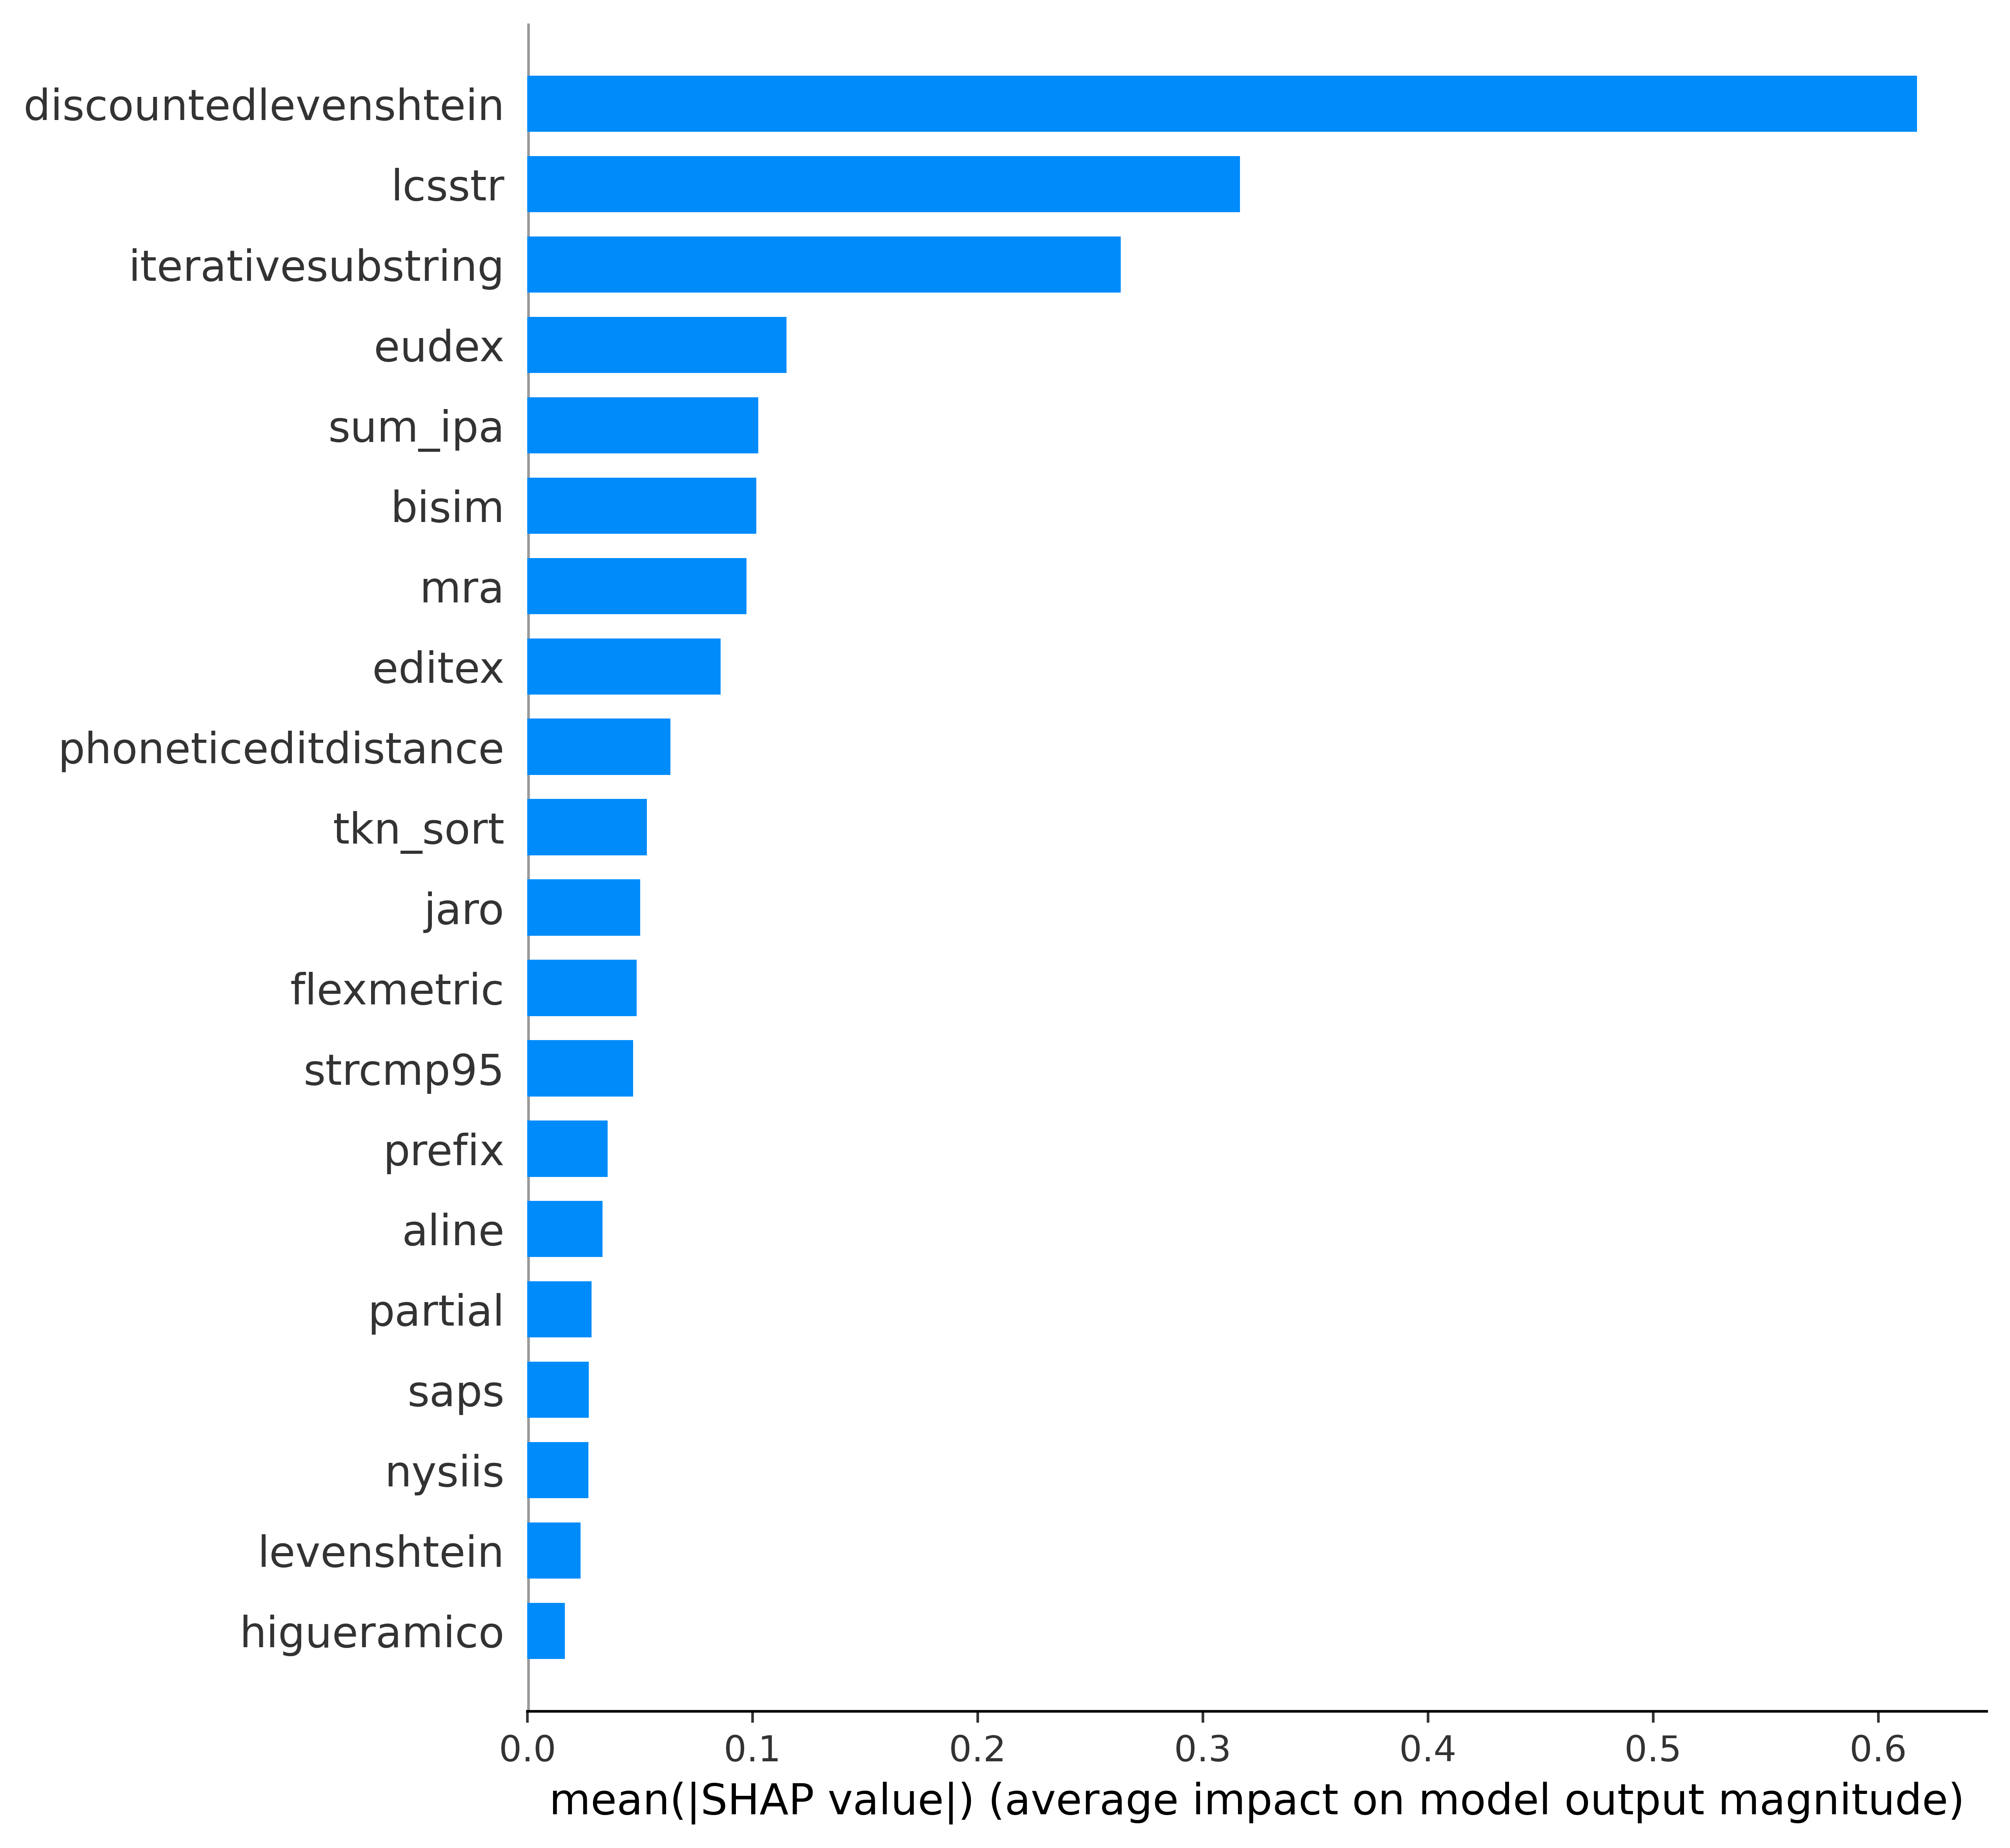

In [195]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar")

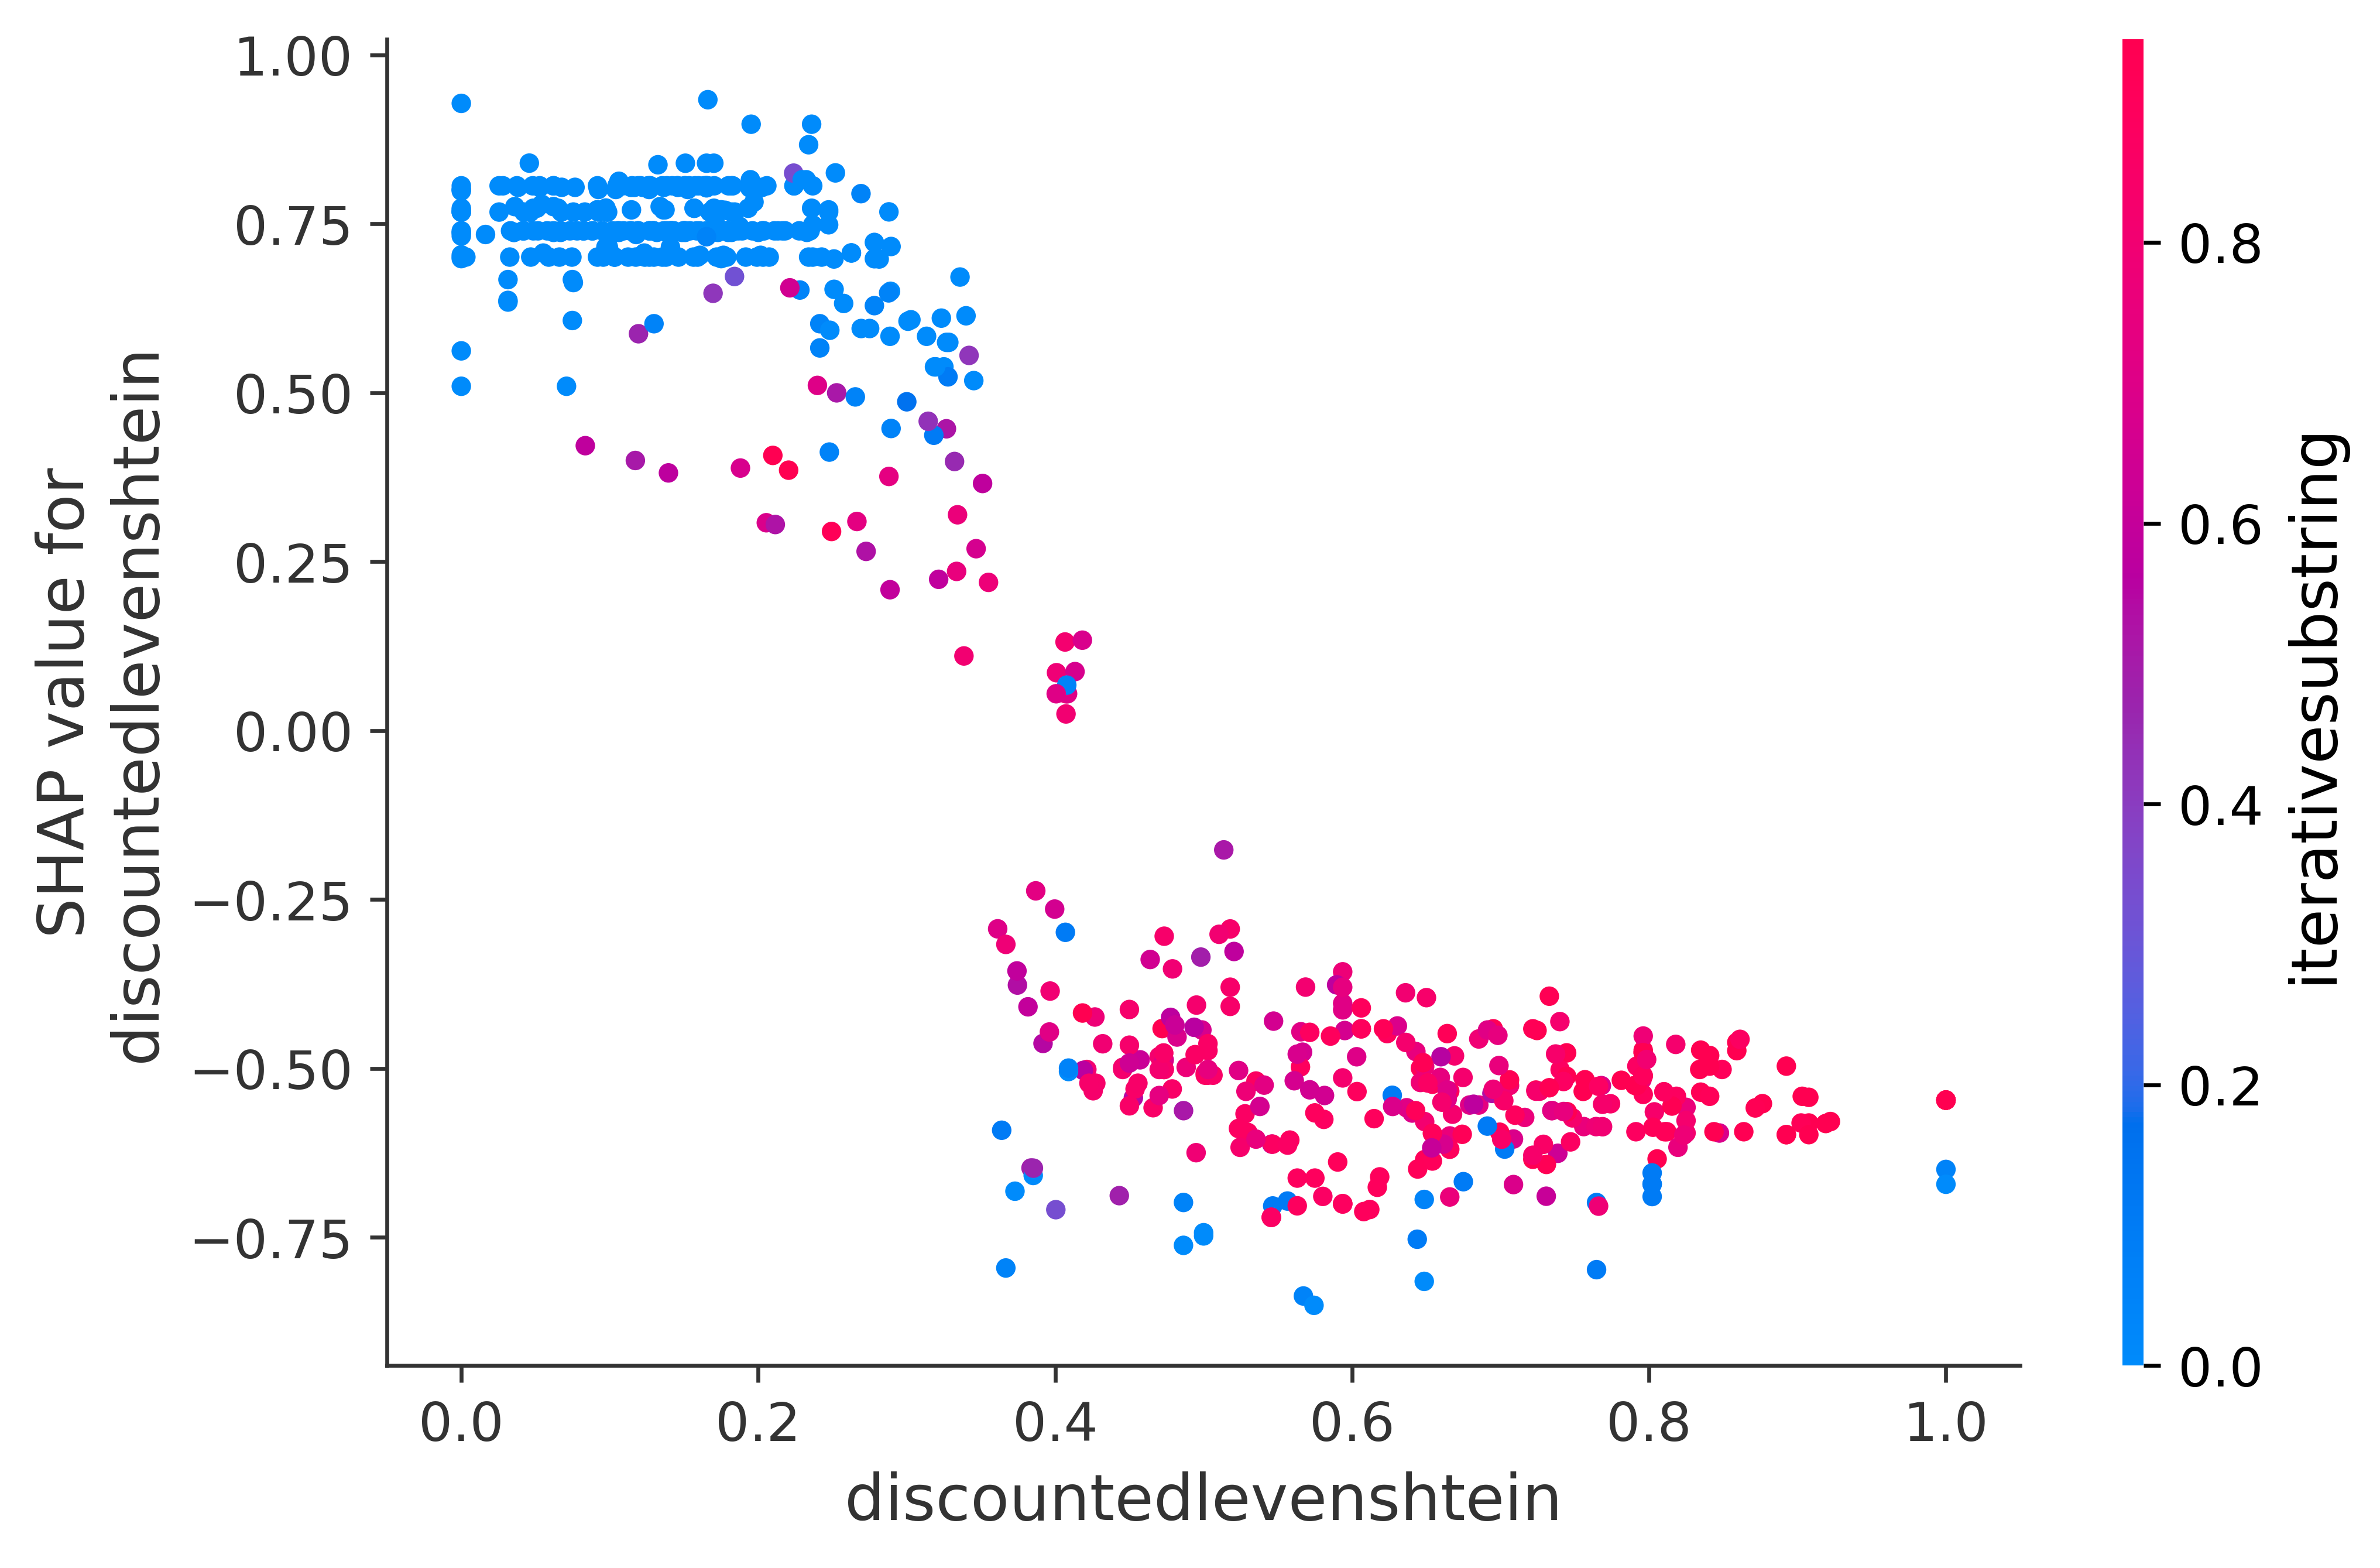

In [100]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


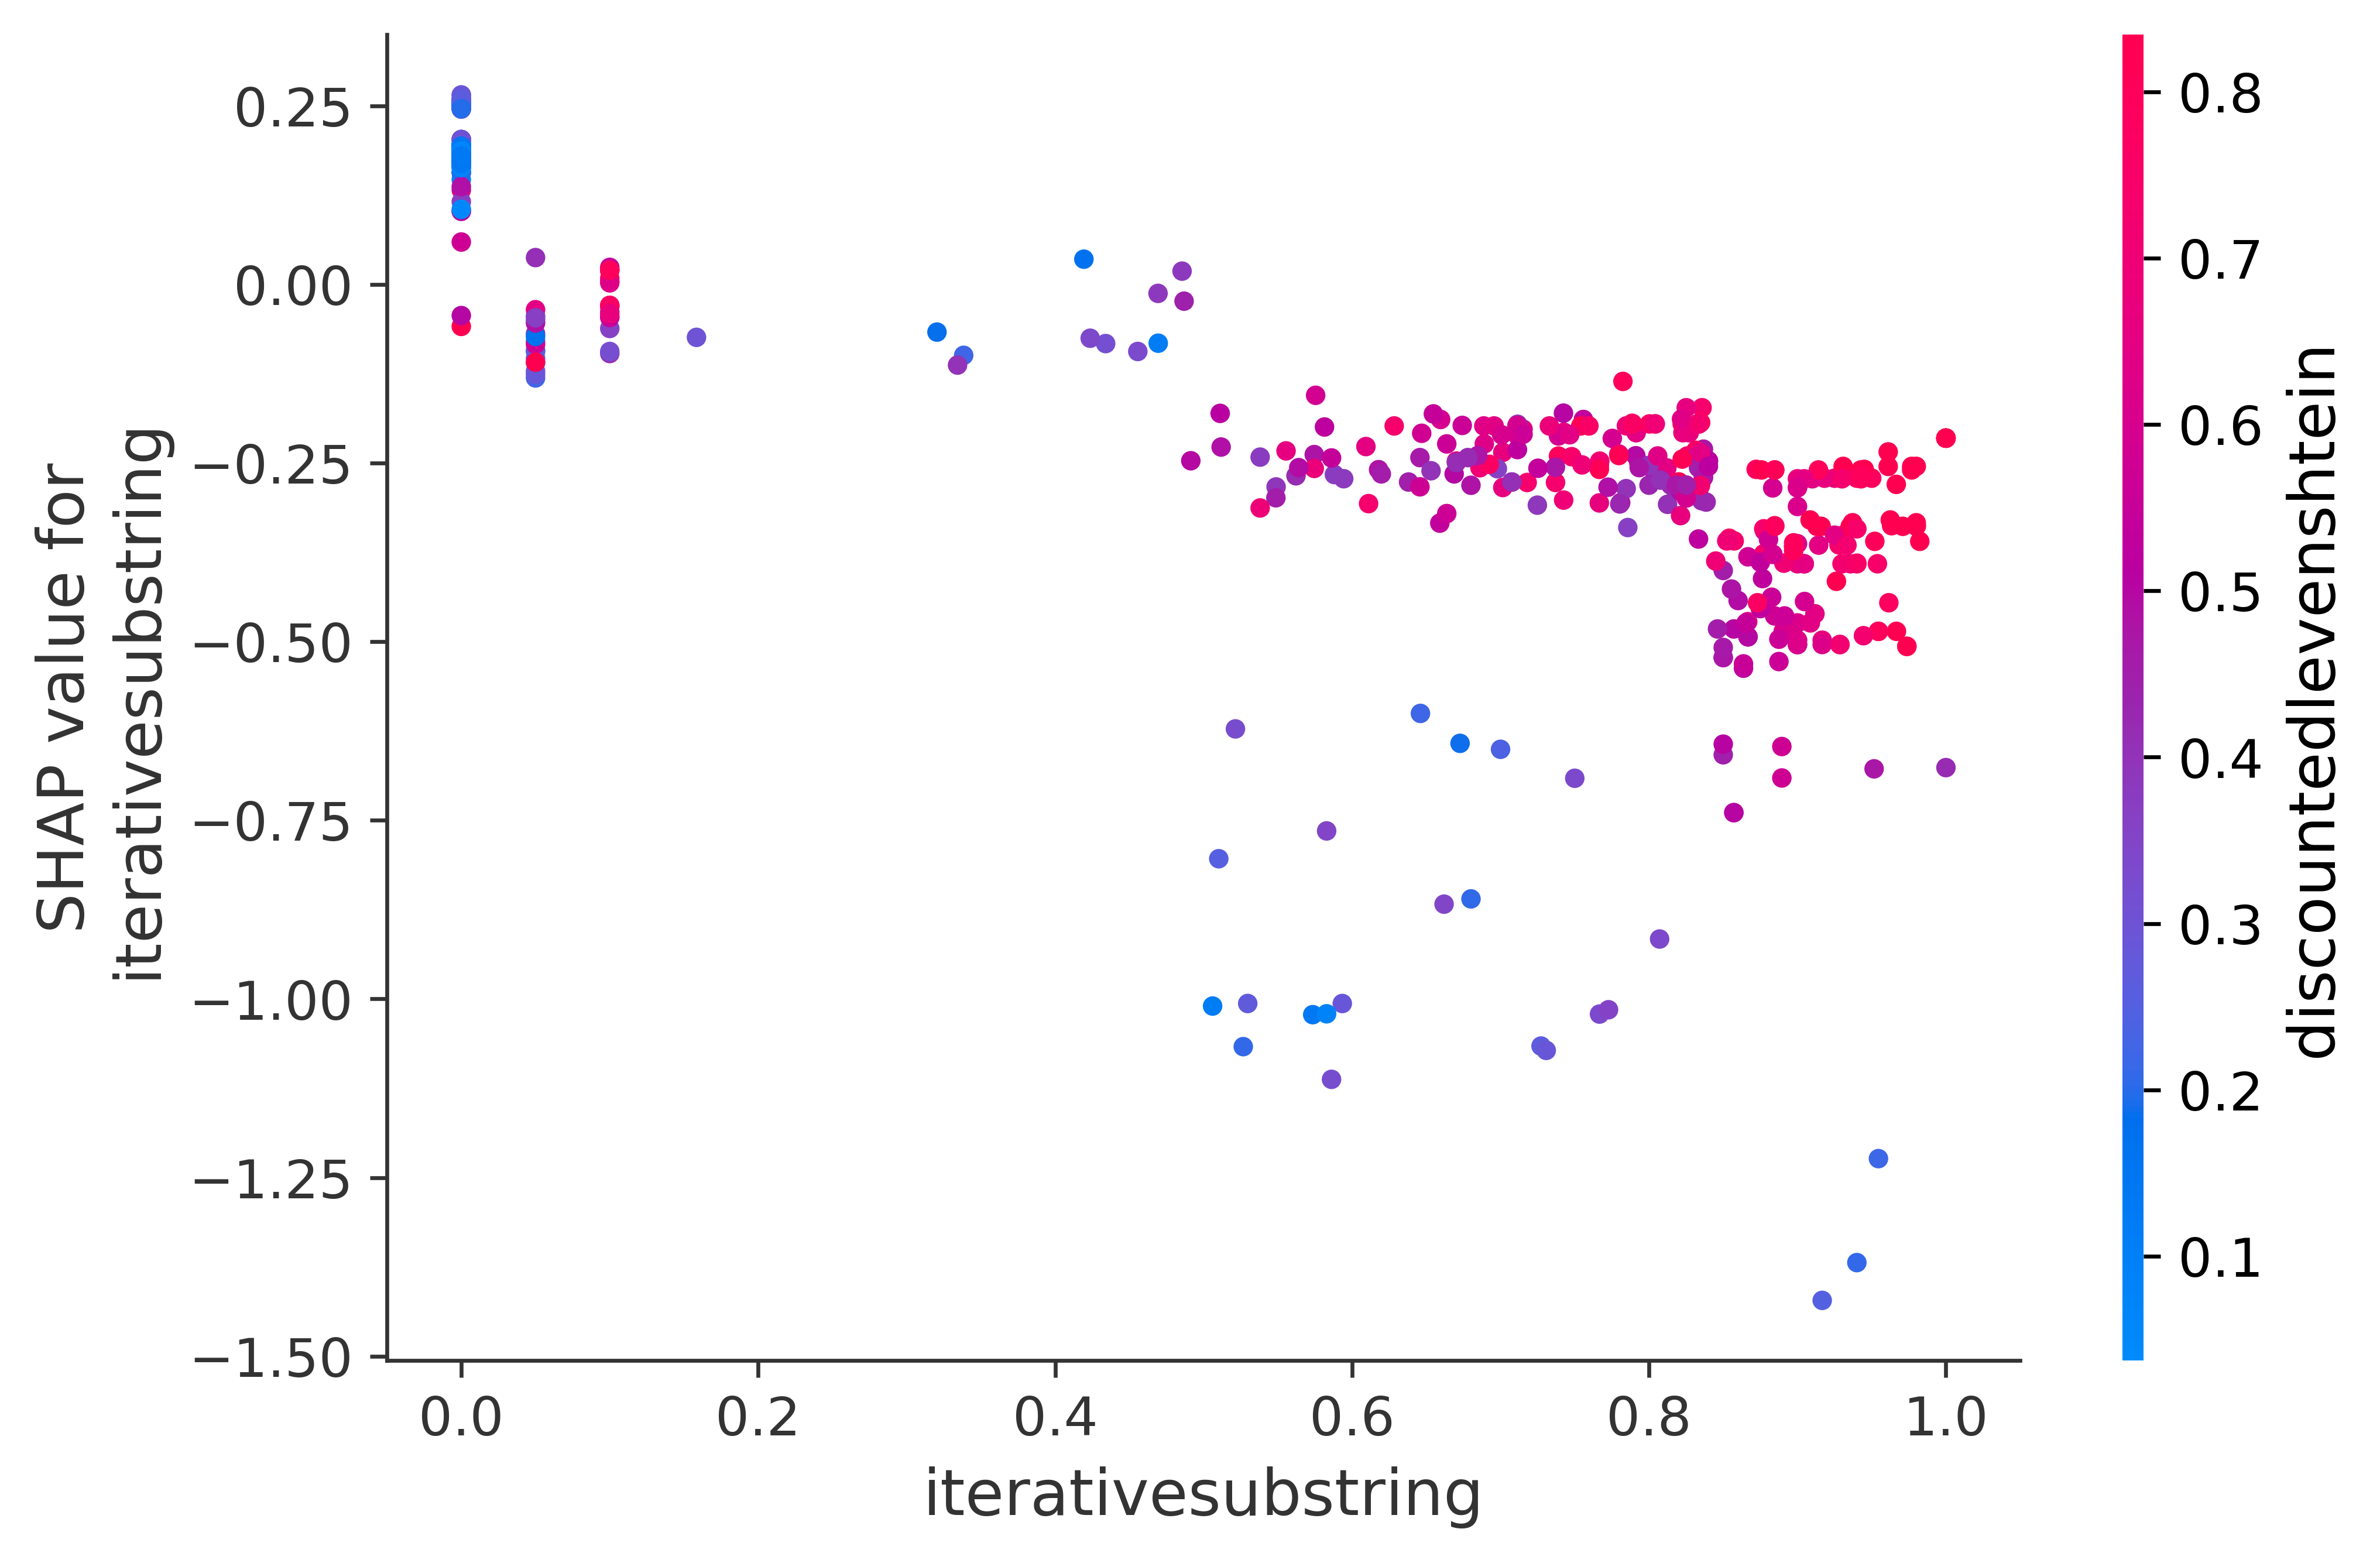

In [196]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


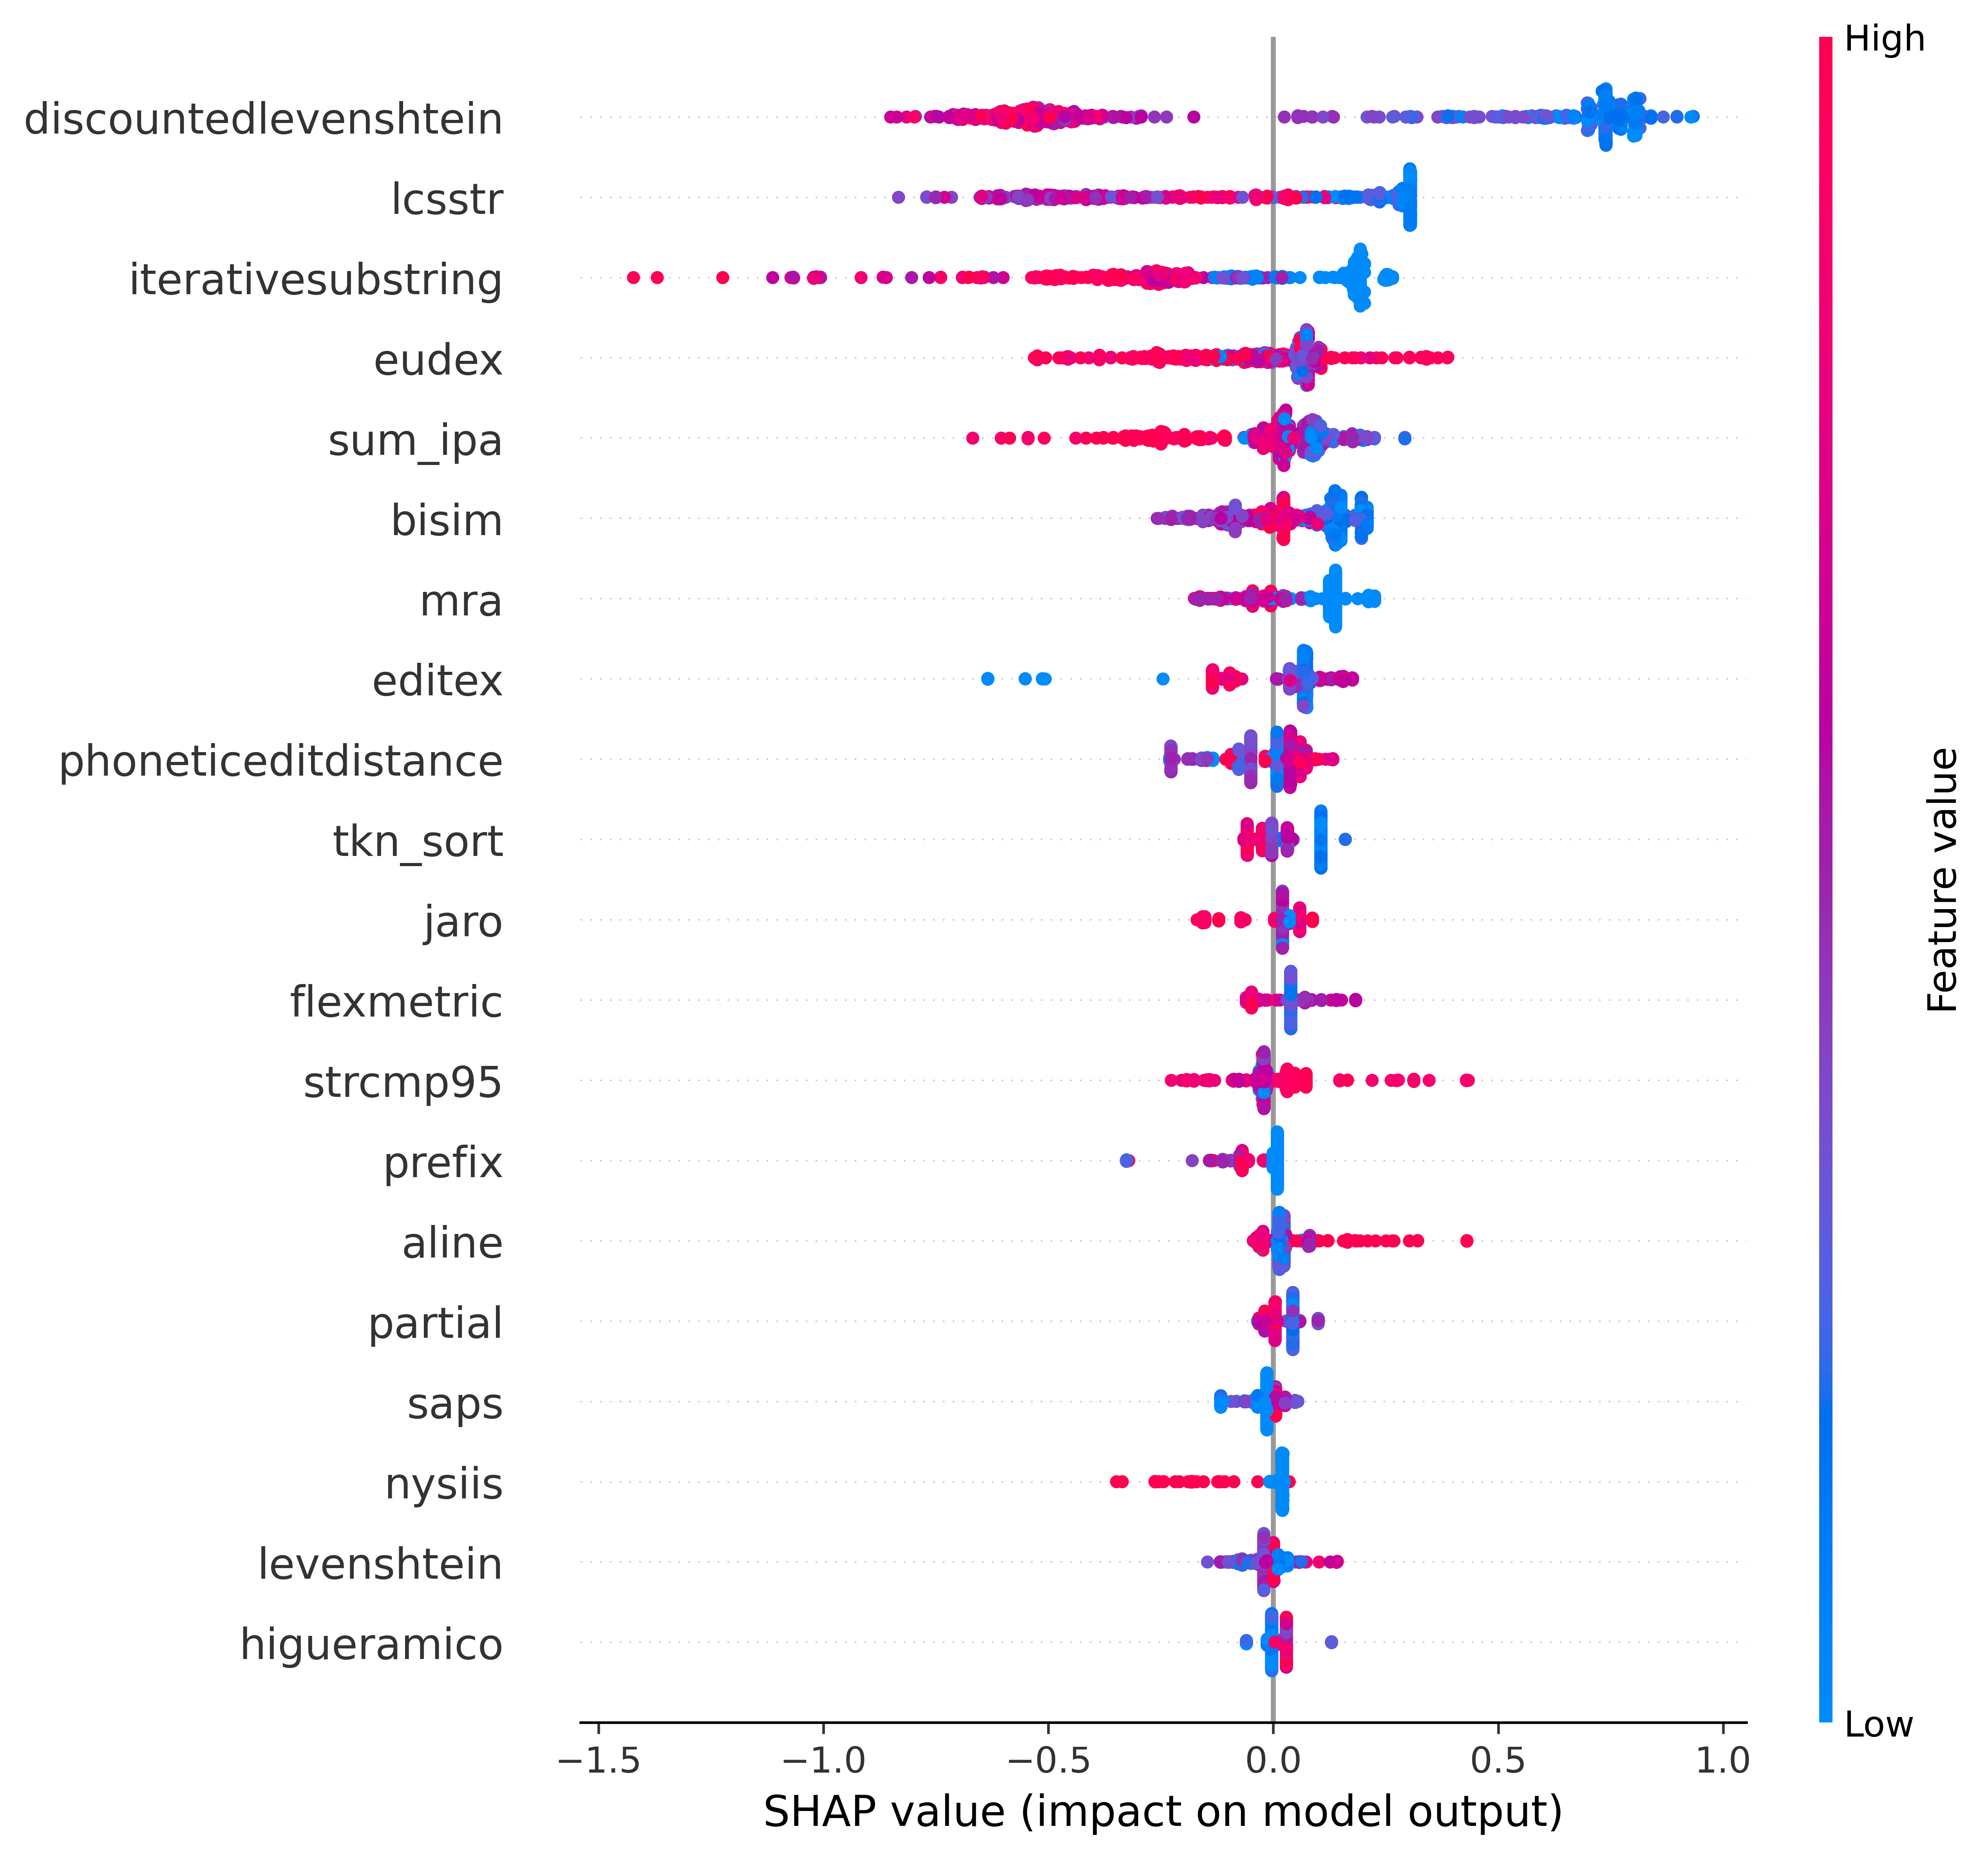

In [197]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(